# Time series forecasting models for weather features

This report is an introduction to time series forecasting using Deep learning. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs). Unlike other machine learning algorithms, long short-term memory recurrent neural networks are capable of automatically learning features from sequence data, support multi-variate data, and can output a variable length sequences that can be used for multi-step forecasting. In this tutorial, you will discover how to develop long short-term memory recurrent neural networks for multi-step time series forecasting of weather features.

This document uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>. The dataset contains many different features such as air temperature, atmospheric pressure, and humidity... These ones were collected every 10 minutes, beginning in 2003. However, only the data collected between 2004 and 2020 will be used. 

The table of contents is the following:

* [Some useful definitions](#[Someusefuldefinitions])    
* [Required packages](#[Requiredpackages])    
* [Load and prepare dataset](#[Loadandpreparedataset])
* [Building Classes](#[BuildingClasses])
* [Parameter setting](#[Parametersetting])
* [Model results](#[Modelresults])
    * [Linear model results](#[Linearmodelresults])
    * [Convolution Neural Network (CNN) model results](#[ConvolutionNeuralNetworkmodelresults])
    * [Recurrent Neural Network (RNN/LSTM) model results](#[RecurrentNeuralNetworkmodelresults])
    * [Stacked LSTM model results](#[StackedLSTMmodelresults])
    * [Stacked GRU model results](#[StackedGRUmodelresults])
    * [Stacked Bidirectional LSTM model results](#[StackedBidirectionalLSTMmodelresults])
    * [Encoder-Decoder LSTM model results](#[Encoder-DecoderLSTMmodelresults]) 
    * [CNN-LSTM Encoder-Decoder model results](#[CNN-LSTMEncoder-Decodermodelresults]) 
    * [ConvLSTM Encoder-Decoder model results](#[ConvLSTMEncoder-Decodermodelresults]) 
* [Performance results](#[Performanceresults])

<a id="[Someusefuldefinitions]"></a>
## Some useful definitions

**What is Time-Series Forecasting ?**

Time-Series forecasting basically means predicting future dependent variable (``y``) based on past independent variable (``x``).

**What is Multivariate Forecasting ?**

If the model predicts dependent variable (``y``) based on one independent variable (``x``), it is called univariate forecasting. For Multivariate forecasting, it simply means predicting dependent variable (``y``) based on more than one independent variable (``x``).

**What is Multi-step Forecasting ?**

If the model predicts a single value for next time-step, it is called one-step forecast. For Multi-step forecast, it means predicting few times-steps ahead.

**What is Multivariate Multi-step Time-Series Forecasting ?**

With all methods combined, the model in this article will predict multi-step ahead of dependent variable (``y``) based on the past two independent variables (``x``).

<a id="[Requiredpackages]"></a>
## Required packages

In [1]:
import os
import random
import time
import IPython.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import tensorflow as tf
import tensorflow_addons as tfa

from math import ceil

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

<a id="[Loadandpreparedataset]"></a>
## Load and prepare datasets

```
def loaddata(sartyear, endyear):
    urlpath = 'https://www.bgc-jena.mpg.de/wetter/'
    urllist = []
    df = pd.DataFrame()
    for year in np.arange(sartyear, endyear, 1):
        urllist.append(urlpath+"mpi_roof_"+str(year)+"a.zip")
        urllist.append(urlpath+"mpi_roof_"+str(year)+"b.zip")
    for url in urllist:
        df = df.append(pd.read_csv(url, encoding='unicode_escape', parse_dates=True, index_col="Date Time"))
    df.index.name = 'datetime'
    return df

df = loaddata(sartyear=2004, endyear=2021)
```

In [2]:
def cleandata(data):
    for col in data.columns:
        data = data[data[col] != -9999.0]
        data = data[data[col] != -9999.99]
    data = data[data['wv (m/s)'] >= 0]
    return data

def findnanrows(df):
    is_NaN = df.isnull() 
    row_has_NaN = is_NaN.any(axis=1) 
    rows_with_NaN = df[row_has_NaN] 
    return rows_with_NaN

def interpolatedata(df):
    filldf = df.groupby(pd.Grouper(freq='10T')).mean()
    dfnan = findnanrows(filldf)
    print("==> %s rows have been filled <==" %len(dfnan))
    filldf = filldf.interpolate().round(2)
    return filldf

In [3]:
class VizData():
    def __init__(self, data):
        self.data = data
        
    def plotfeatures(self, mode, title):
        features = self.data.columns.tolist()
        plot_features = self.data.groupby(pd.Grouper(freq=str(mode)+'T')).mean()
        plot_features = plot_features[features]
        plot_features.index = plot_features.index
        ncols = 2
        nrows = ceil(len(features)/ncols)
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10), facecolor="w", edgecolor="k")
        for i, feature in enumerate(features):
            axes[i // ncols, i % ncols].plot(plot_features[feature])
            axes[i // ncols, i % ncols].set_title(f'{feature} - {title}')     
        plt.tight_layout()
        plt.show()

    def plothist2d(self, feature):
        f = self.data.columns.tolist()
        features = [x for x in f if x != feature]
        ncols = 2
        nrows = ceil(len(features)/ncols)
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
        for i, feature_x in enumerate(features):
            if i == nrows * ncols - 2:
                ax = plt.subplot(nrows,1,ncols)
                counts, xedges, yedges, img = plt.hist2d(self.data[feature_x], self.data[feature], bins=(50, 50))
                ax.set_xlabel(f'{feature_x}')
                ax.set_ylabel(f'{feature}')
                ax.axis('tight')  
                plt.colorbar(img, ax=ax)
                plt.gca()
            else:
                ax = plt.subplot(nrows,ncols,i+1)
                counts, xedges, yedges, img = ax.hist2d(self.data[feature_x], self.data[feature], bins=(50, 50))
                ax.set_xlabel(f'{feature_x}')
                ax.set_ylabel(f'{feature}')
                ax.axis('tight')  
                plt.colorbar(img, ax=ax)
                plt.gca()
        plt.show()

    def plotbox(self, mode):
        plot_features = self.data.groupby(pd.Grouper(freq=str(60)+'T')).mean().copy()
        plot_features[mode] = [eval('x.%s'%mode) for x in plot_features.index] 
        plot_features.boxplot('wv (m/s)', by=mode, figsize=(12, 8), grid=False)
        plt.show()

In [4]:
weather = pd.read_csv("../input/jena-weather-dataset/jena_weather_2004_2020.csv", parse_dates=True, index_col="Date Time")
weather.index.name = 'datetime'
weather = weather[[x for x in weather.columns if x != 'CO2 (ppm)']]

print("Size before cleaning data:", weather.shape)
weather = cleandata(data=weather)
print("Size after cleaning data:", weather.shape)

print("Size before filling data:", weather.shape)
#weather = filldata(weather)
weather = interpolatedata(weather)
print("Size after filling data:", weather.shape)

weather.head()

Size before cleaning data: (893974, 20)
Size after cleaning data: (892975, 20)
Size before filling data: (892975, 20)
==> 1595 rows have been filled <==
Size after filling data: (894240, 20)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC)
datetime,,,,,,,,,,,,,,,,,,,,
2004-01-01 00:10:00,996.82,-0.84,272.57,-1.23,97.2,5.74,5.58,0.16,3.49,5.60,1272.50,2.53,3.63,26.15,0.0,0.0,0.0,0.0,0.0,8.57
2004-01-01 00:20:00,996.69,-0.78,272.64,-1.22,96.8,5.77,5.59,0.18,3.49,5.60,1272.04,2.08,3.25,29.38,0.0,0.0,0.0,0.0,0.0,9.07
2004-01-01 00:30:00,996.69,-0.77,272.64,-1.29,96.3,5.77,5.56,0.21,3.48,5.58,1272.04,2.09,3.75,19.44,0.0,0.0,0.0,0.0,0.0,9.27
2004-01-01 00:40:00,996.67,-0.77,272.65,-1.39,95.6,5.77,5.52,0.25,3.45,5.54,1272.04,1.94,3.63,19.66,0.0,0.0,0.0,0.0,0.0,8.94
2004-01-01 00:50:00,996.52,-0.77,272.66,-1.44,95.2,5.77,5.49,0.28,3.44,5.51,1271.86,1.28,2.25,21.53,0.0,0.0,0.0,0.0,0.0,8.46


In [5]:
weather.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),894240.0,989.475921,8.639153,913.60,984.38,989.79,995.17,1020.07
T (degC),894240.0,9.679617,8.256389,-23.01,3.52,9.55,15.59,37.28
Tpot (K),894240.0,283.701809,8.359852,250.60,277.55,283.61,289.66,311.34
Tdew (degC),894240.0,4.993727,6.523026,-25.01,0.32,5.22,10.02,23.11
rh (%),894240.0,75.182544,16.800309,12.95,64.10,78.40,88.80,100.00
VPmax (mbar),894240.0,13.727357,7.746555,0.95,7.86,11.93,17.74,63.77
VPact (mbar),894240.0,9.513014,4.082564,0.79,6.25,8.87,12.31,28.32
VPdef (mbar),894240.0,4.214258,5.047451,0.00,0.95,2.28,5.51,47.81
sh (g/kg),894240.0,6.008240,2.592449,0.50,3.94,5.59,7.78,18.13
H2OC (mmol/mol),894240.0,9.617912,4.134115,0.80,6.32,8.96,12.45,28.82


In [6]:
usecols = ["T (degC)", "rh (%)", "p (mbar)", "wv (m/s)"]
weather = weather[usecols]
print("weather dataset shape:", weather.shape)

weather dataset shape: (894240, 4)


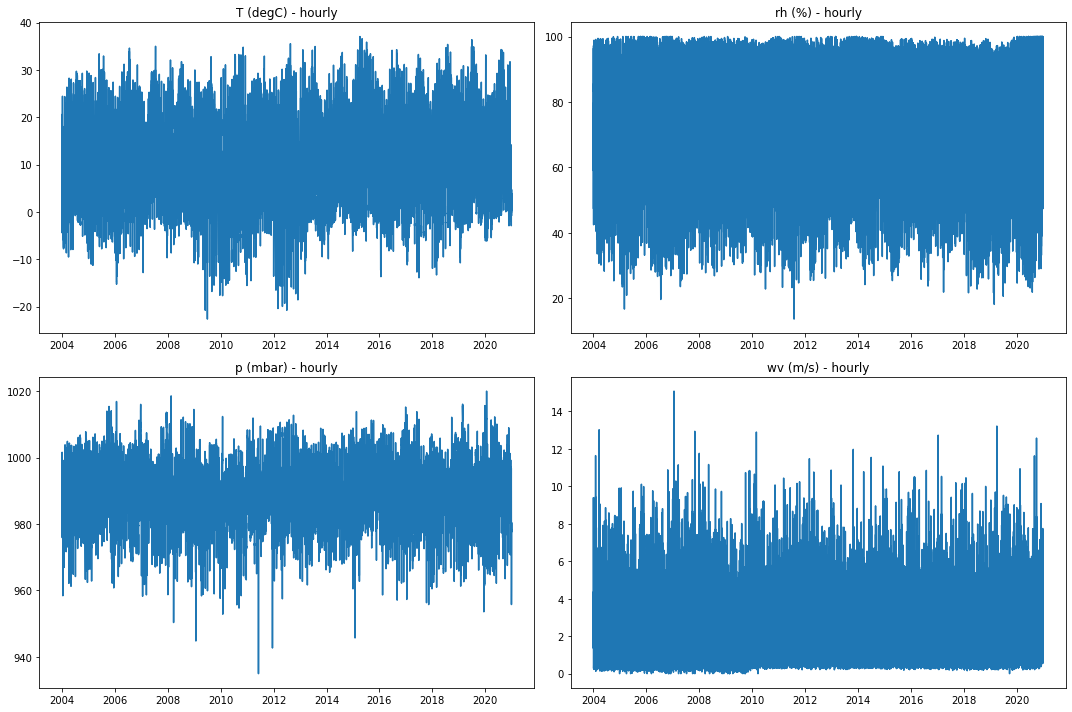

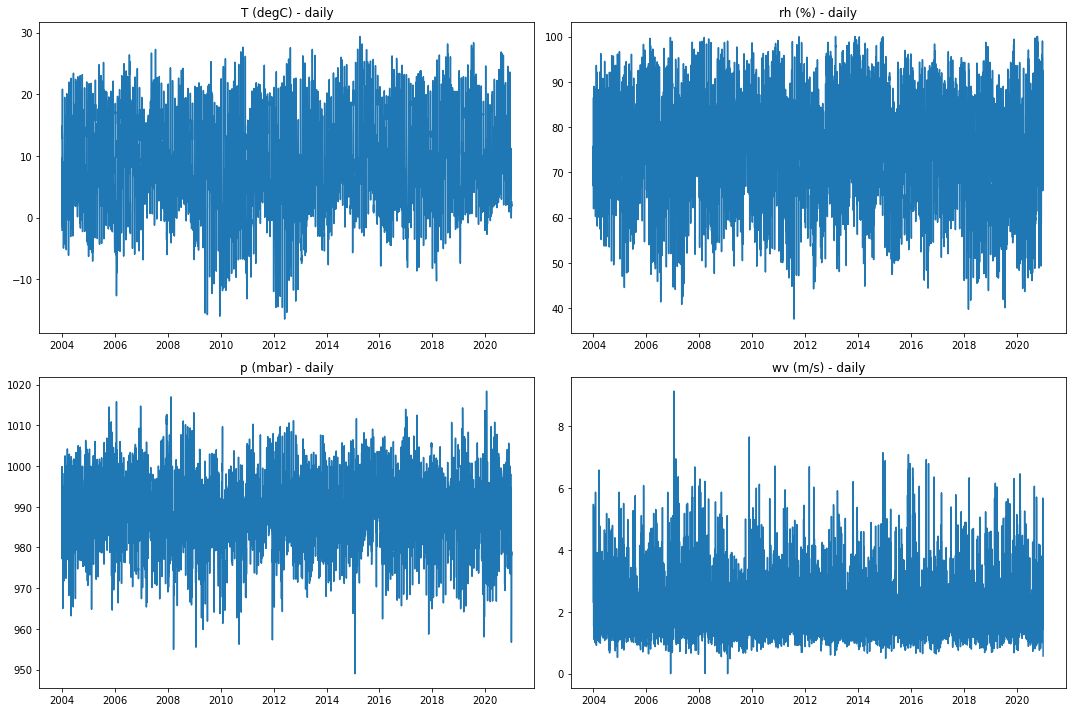

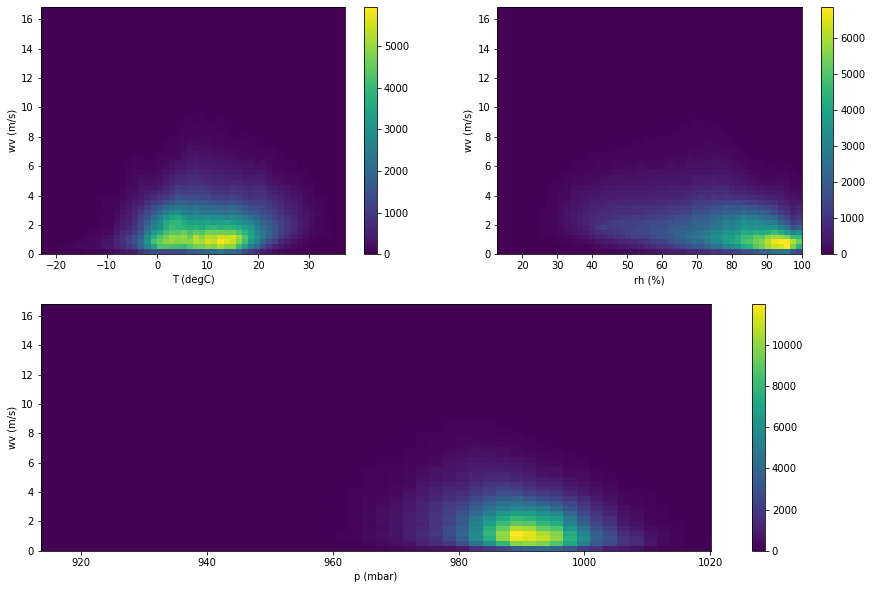

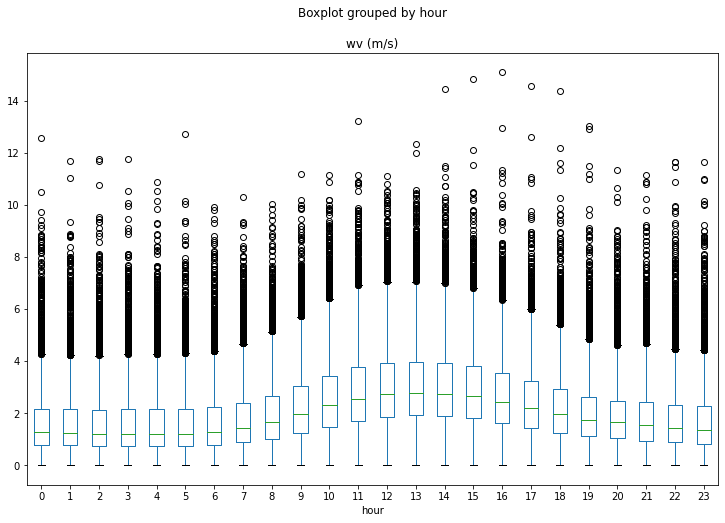

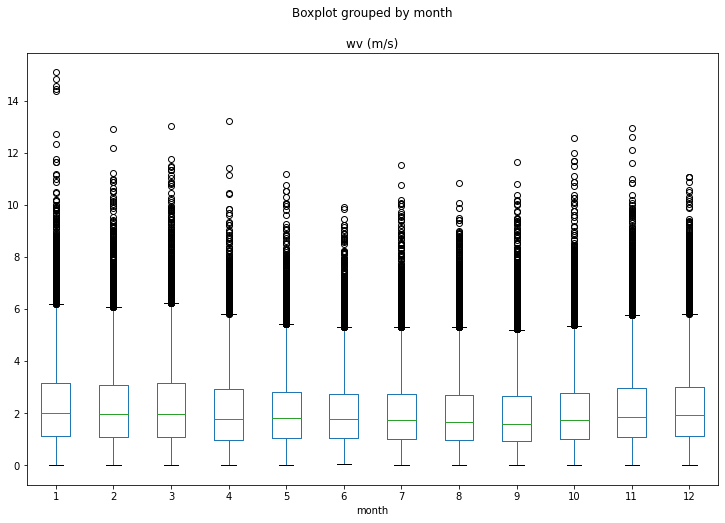

In [7]:
vd = VizData(data=weather)
vd.plotfeatures(mode=60, title="hourly")
vd.plotfeatures(mode=60*24, title="daily")
vd.plothist2d(feature="wv (m/s)")
vd.plotbox(mode="hour")
vd.plotbox(mode="month")

<a id="[BuildingClasses]"></a>
## Building Classes

In [8]:
class DataPreprocessing():
    def __init__(self, data, sampling_window, **kwargs):
        self.data = data
        self.sampling_window = sampling_window
        self.trainsize = kwargs.get('trainsize', 0.7)
        self.valsize = kwargs.get('valsize', 0.2)

    def datasplit(self, **kwargs):
        self.addcyclics = kwargs.get('addcyclics', False)
        self.normalize = kwargs.get('normalize', None)
        self.features = kwargs.get('features', None)
        
        self.resample_data = self.data.resample(str(self.sampling_window)+'T').mean()
        
        if self.resample_data.isna().sum().sum() > 0:
            raise Exception(f"Oops! there are some NaN values in resampled data.")

        if self.features is not None:
            self.resample_data = self.resample_data[self.features]
        if self.addcyclics:
            self.resample_data = self.__class__.cyclical(self.resample_data)   
            self.features = self.resample_data.columns
        
        self.train_df = self.resample_data[0:int(len(self.resample_data)*self.trainsize)]
        self.val_df = self.resample_data[int(len(self.resample_data)*self.trainsize):int(len(self.resample_data)*(self.trainsize+self.valsize))]
        self.test_df = self.resample_data[int(len(self.resample_data)*(self.trainsize+self.valsize)):]
                
        if self.normalize is not None:
            if self.normalize == 'MinMaxScaler':
                self.scaler = MinMaxScaler(feature_range=(0, 1))
            elif self.normalize == 'StandardScaler':
                self.scaler = StandardScaler()
            # normalizing input features
            self.train_df = pd.DataFrame(self.scaler.fit_transform(self.train_df), columns=self.train_df.columns, index=self.train_df.index)
            self.val_df = pd.DataFrame(self.scaler.transform(self.val_df), columns=self.val_df.columns, index=self.val_df.index)
            self.test_df = pd.DataFrame(self.scaler.transform(self.test_df), columns=self.test_df.columns, index=self.test_df.index)
            
        return self.train_df, self.val_df, self.test_df
    
    @staticmethod
    def cyclical(data):
        data = data.copy()
        # Extracting the hour of day
        data["hour"] = [x.hour for x in data.index]
        # Creating the cyclical daily feature 
        data["day_cos"] = [np.cos(x * (2 * np.pi / 24)) for x in data["hour"]]
        data["day_sin"] = [np.sin(x * (2 * np.pi / 24)) for x in data["hour"]]
        # Extracting the timestamp from the datetime object 
        data["timestamp"] = [x.timestamp() for x in data.index]
        # Seconds in day 
        s = 24 * 60 * 60
        # Seconds in year 
        year = (365.25) * s
        data["month_cos"] = [np.cos((x) * (2 * np.pi / year)) for x in data["timestamp"]]
        data["month_sin"] = [np.sin((x) * (2 * np.pi / year)) for x in data["timestamp"]]
        data = data.drop(['hour', 'timestamp'], axis=1)
        return data

In [9]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 batch_size, sequence_stride,
                 train_df, val_df, test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.sequence_stride = sequence_stride

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
            self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift + label_width

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.input_width + self.shift
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Offset: {self.shift}',
            f'Label column name(s): {self.label_columns}',
        ])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    
    def make_dataset(self, data, sequence_stride):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=sequence_stride, 
            shuffle=False,
            batch_size=self.batch_size,
        )
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df, self.sequence_stride)
    @property
    def val(self):
        return self.make_dataset(self.val_df, self.sequence_stride)
    @property
    def test(self):
        return self.make_dataset(self.test_df, self.sequence_stride)
    
    @property
    def flattrain(self):
        return self.make_dataset(self.train_df, self.label_width)
    @property
    def flatval(self):
        return self.make_dataset(self.val_df, self.label_width)
    @property
    def flattest(self):
        return self.make_dataset(self.test_df, self.label_width)
 
    def randomplots(self, mc=None, max_subplots=3, **kwargs):   
        plot_col = kwargs.get('plot_col', self.label_columns[0])

        real_x = np.concatenate(list(map(lambda x: x[0].numpy(), self.flattest)))
        real_y = np.concatenate(list(map(lambda x: x[1].numpy(), self.flattest)))  

        plot_col_index = self.column_indices[plot_col]
        indexes = random.sample(range(len(real_x)), max_subplots)

        if mc is not None:
            reshape_real_x = mc.reshape(real_x)
            max_subplots = max_subplots + 1

        plt.figure(figsize=(12, 8))
        for n in range(max_subplots):
            plt.subplot(max_subplots, 1, n+1)
            if n == max_subplots - 1 and mc is not None: 
                plt.plot(real_y[:, :, label_col_index].reshape(-1, 1))
                plt.plot(predictions.reshape(-1, 1))

            else: 
                plt.plot(self.input_indices, real_x[indexes[n], :, plot_col_index], 
                         label='Inputs', marker='.', zorder=-10)

                if self.label_columns:
                    label_col_index = self.label_columns_indices.get(plot_col, None)
                else:
                    label_col_index = plot_col_index

                if label_col_index is None:
                    continue

                plt.scatter(self.label_indices, real_y[indexes[n], :, label_col_index], 
                            marker='p', edgecolors='k', label='Labels', 
                            c='#2ca02c', s=64)
                if mc is not None:
                    predictions = mc.model.predict(reshape_real_x)
                    plt.scatter(self.label_indices, predictions[indexes[n], :], 
                                marker='*', edgecolors='k', label='Predictions',
                                c='#ff7f0e', s=64)
            if n == 0:
                plt.legend()
                plt.title(f'{plot_col} [scaled]')
        plt.xlabel('Timesteps')
        
    def plotforecast(self, mc, title, **kwargs):
        withinputs = kwargs.get('withinputs', False)
        windows = kwargs.get('windows', None)
        labels = ["Actual values", "Predicted values"]

        real_x = np.concatenate(list(map(lambda x: x[0].numpy(), self.flattest)))
        real_y = np.concatenate(list(map(lambda x: x[1].numpy(), self.flattest)))
        pred_y = mc.model.predict(mc.reshape(real_x))

        real_y = real_y.reshape(-1, 1)
        pred_y = pred_y.reshape(-1, 1)

        plt.figure(figsize=(15,5))
        if withinputs:
            plt.plot(self.test_df[self.label_columns].values[:self.input_width+len(pred_y[:windows])], label=labels[0])
            plt.plot(np.arange(self.input_width, self.input_width+len(pred_y[:windows])), pred_y[:windows], label=labels[1])
        else:
            plt.plot(real_y[:windows], label=labels[0])
            plt.plot(pred_y[:windows], label=labels[1])
        plt.title(f'{title}: {self.input_width} previous timesteps-based {self.label_width} future timesteps forecasting')
        plt.xlabel("Test dataset points")
        plt.legend(frameon=False)
        plt.show()

In [10]:
class ModelingClass():
    def __init__(self, mapdataset, epochs, patience, learning_rate, loss, metrics, verbose=1):
        self.mapdataset = mapdataset
        self.epochs = epochs
        self.patience = patience
        self.learning_rate = learning_rate
        self.verbose = verbose
        self.loss = loss 
        self.metrics = metrics
        self.label_feature_number = list(map(lambda x: x[1].numpy(), mapdataset.train.take(1)))[0].shape[2]
 
    def reshape(self, data):
        return data
    
    # build the model
    def modelbuild(self):
        # define model
        model = None
        return model
        
    def traincallback(self):
        # simple early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=self.patience, verbose=1)
        return early_stopping 
    
    # train the model
    def train(self):
        # Building the model
        self.model = self.modelbuild()
        # Initiating the optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # Instantiate an optimizer before passing it to model.compile() or pass it by its string identifier.
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
        # fit network
        if (self.mapdataset.val is not None):
            self.history = self.model.fit(
                self.mapdataset.train,
                validation_data=self.mapdataset.val,    
                epochs=self.epochs, 
                verbose=self.verbose, 
                shuffle=False,
                callbacks=[self.traincallback()],
            )
        else:
            self.history = self.model.fit(
                self.mapdataset.train,    
                epochs=self.epochs, 
                verbose=self.verbose, 
                shuffle=False,
                callbacks=[self.traincallback()],
            )
        return self.history
    
    def computemetrics(self, mapdata): 
        real_y = np.concatenate(list(map(lambda x: x[1].numpy(), mapdata)))
        real_y = real_y.reshape(real_y.shape[0], real_y.shape[1])
        pred_y = self.model.predict(mapdata)
        pred_y = pred_y.reshape(pred_y.shape[0], pred_y.shape[1])

        RMSE = mean_squared_error(real_y, pred_y, squared=False)
        MSE = mean_squared_error(real_y, pred_y)
        MAE = mean_absolute_error(real_y, pred_y)
        MAPE = 100*mean_absolute_percentage_error(real_y, pred_y)
        R2 = r2_score(real_y, pred_y)   
        # calculate the metric score for each timestep
        rmse_scores = mean_squared_error(real_y, pred_y, multioutput='raw_values', squared=False)
        mse_scores = mean_squared_error(real_y, pred_y, multioutput='raw_values')
        mae_scores = mean_absolute_error(real_y, pred_y, multioutput='raw_values')
        mape_scores = 100*mean_absolute_percentage_error(real_y, pred_y, multioutput='raw_values')
        r2_scores = r2_score(real_y, pred_y, multioutput='raw_values')
        print('rmse: %.4f [%s]' %(RMSE, ', '.join(['%.4f' % s for s in rmse_scores])))
        print('mse : %.4f [%s]' %(MSE, ', '.join(['%.4f' % s for s in mse_scores])))
        print('mae : %.4f [%s]' %(MAE, ', '.join(['%.4f' % s for s in mae_scores])))
        print('mape: %.4f [%s]' %(MAPE, ', '.join(['%.4f' % s for s in mape_scores])))
        print('r2  : %.4f [%s]' %(R2, ', '.join(['%.4f' % s for s in r2_scores])))
    
    @property
    def trainmetrics(self):
        return self.computemetrics(self.mapdataset.train)
    @property
    def valmetrics(self):
        return self.computemetrics(self.mapdataset.val)
    @property
    def testmetrics(self):
        return self.computemetrics(self.mapdataset.test)
    
    def lossplot(self, **kwargs):
        if len(self.model.metrics_names) <= 2:
            l, c = 1, 2
        else:
            l, c = (len(self.model.metrics_names)//2)+1, 2
        title = kwargs.get('title', "")
        epochs = range(len(self.history.history[self.model.metrics_names[0]]))
        plt.figure(figsize=(15,3.5*l))
        for i in range(len(self.model.metrics_names)):
            plt.subplot(l,c,i+1)
            if self.model.metrics_names[i] == "loss":
                plt.plot(epochs, self.history.history[self.model.metrics_names[i]], "b", label="Training "+self.loss[0]+'*')
                plt.plot(epochs, self.history.history["val_"+self.model.metrics_names[i]], "green", label="Validation "+"val_"+self.loss[0]+'*')
                plt.xlabel("Epochs")
                plt.ylabel(self.loss[0]+'*')
                plt.legend(frameon=False)
            else:
                plt.plot(epochs, self.history.history[self.model.metrics_names[i]], "b", label="Training "+self.model.metrics_names[i])
                plt.plot(epochs, self.history.history["val_"+self.model.metrics_names[i]], "green", label="Validation "+"val_"+self.model.metrics_names[i])
                plt.xlabel("Epochs")
                plt.ylabel(self.model.metrics_names[i])
                plt.legend(frameon=False)
        plt.suptitle("Training and validation losses: {}".format(title))
        plt.subplots_adjust(hspace=0.4)
        plt.show()
    
    def modelevaluate(self, train_performance, val_performance, test_performance):
        for x in ["train", "val", "test"]:
            print("\nModel evaluation on %s dataset:\n"%x)
            eval("%s_performance"%x)[self.__class__.__name__] = self.model.evaluate(eval("self.mapdataset.%s"%x))
            print(list(map(lambda x: round(x, 4), eval("%s_performance"%x)[self.__class__.__name__])))
        return train_performance, val_performance, test_performance

<a id="[Parametersetting]"></a>
## Parameter setting

In [11]:
sampling_window = 60
addcyclics = False
normalize = True
#normalize_type = "StandardScaler"
normalize_type = "MinMaxScaler"

n_input, n_output = 48, 7 #48, 7
sequence_stride = 1 
epochs, batch_size, learning_rate, patience = 200, 2**7, 0.001, 10 #150, 2**7, 0.001, 10
loss, metrics = ['mse'], ['mae', 'mape', tfa.metrics.RSquare(name='r2', dtype=tf.float32, y_shape=(n_output, 1))] 

features = ["p (mbar)", "T (degC)", "rh (%)", "wv (m/s)"]

train_performance = {}
val_performance = {}
test_performance = {}

In [12]:
def run(data, modelingclassname, title, train_performance, val_performance, test_performance):
    
    start = time.time()
    
    dp = DataPreprocessing(data=data, sampling_window=sampling_window, trainsize=0.7, valsize=0.2)
    train_df, val_df, test_df = dp.datasplit(features=features, addcyclics=addcyclics, normalize=normalize_type)

    mw = WindowGenerator(
        train_df=train_df, 
        val_df=val_df, 
        test_df=test_df,
        input_width=n_input,
        label_width=n_output,
        shift=0,
        label_columns=['wv (m/s)'],
        batch_size=batch_size,
        sequence_stride=sequence_stride,
    )       
        
    mc = modelingclassname(
        mapdataset=mw,
        epochs=epochs,
        patience=patience,
        learning_rate=learning_rate,
        loss=loss, 
        metrics=metrics)

    history = mc.train()
    
    IPython.display.clear_output()
    
    print(mw)
    
    for example_inputs, example_labels in mw.train.take(1):
    #for example_inputs, example_labels in mw.train:
        print(f'\nInput shape (batch size, timesteps, features): {example_inputs.shape}')
        print(f'Label shape (batch size, timesteps, features): {example_labels.shape}\n')

    display(tf.keras.utils.plot_model(mc.model, mc.__class__.__name__+"_model_with_shape_info.png", show_shapes=True, show_layer_names=True))
        
    train_performance, val_performance, test_performance = mc.modelevaluate(train_performance, val_performance, test_performance)
        
    print("\nModeling metrics on train data set:\n")
    mc.trainmetrics
    print("\nModeling metrics on validation data set:\n")
    mc.valmetrics
    print("\nModeling metrics on test data set:\n")
    mc.testmetrics

    mc.lossplot(title=title)
 
    mw.randomplots(mc)

    mw.plotforecast(mc, title=title, windows=500, withinputs=True)
    
    print("Time taken with the %s model: %.2f sec" %(mc.__class__.__name__, time.time()-start))
    
    return dp, mw, mc, train_performance, val_performance, test_performance

<a id="[Modelresults]"></a>
## Model results

<a id="[Linearmodelresults]"></a>
### Linear model results

In [13]:
class Linear(ModelingClass):
    # build the model
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            # Take the last time-step.
            # Shape [batch, time, features] => [batch, 1, features]
            tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
            # Shape => [batch, 1, out_steps*features]
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['wv (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)



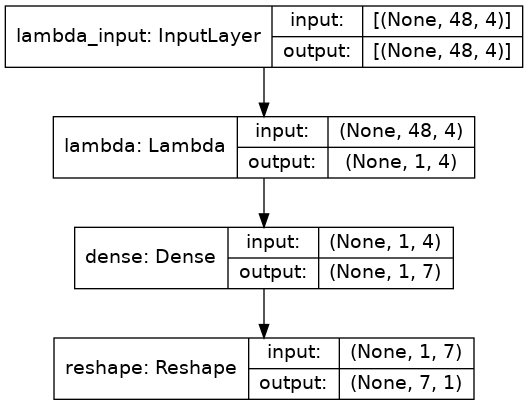


Model evaluation on train dataset:

815/815 [==============================] - 6s 8ms/step - loss: 0.0063 - mae: 0.0575 - mape: 154490.7344 - r2: 0.3711
[0.0063, 0.0575, 154490.7344, 0.3711]

Model evaluation on val dataset:

233/233 [==============================] - 2s 8ms/step - loss: 0.0058 - mae: 0.0549 - mape: 60.4915 - r2: 0.4029
[0.0058, 0.0549, 60.4915, 0.4029]

Model evaluation on test dataset:

117/117 [==============================] - 1s 7ms/step - loss: 0.0062 - mae: 0.0562 - mape: 52868.8750 - r2: 0.3860
[0.0062, 0.0562, 52868.875, 0.386]

Modeling metrics on train data set:

rmse: 0.0781 [0.0489, 0.0660, 0.0761, 0.0831, 0.0879, 0.0911, 0.0932]
mse : 0.0063 [0.0024, 0.0044, 0.0058, 0.0069, 0.0077, 0.0083, 0.0087]
mae : 0.0575 [0.0344, 0.0473, 0.0555, 0.0615, 0.0656, 0.0684, 0.0702]
mape: 69546534502400.0000 [20128729137152.0000, 40337674338304.0000, 58410934468608.0000, 73894551617536.0000, 87589356830720.0000, 98828002787328.0000, 107636460617728.0000]
r2  : 0.3711 [0.

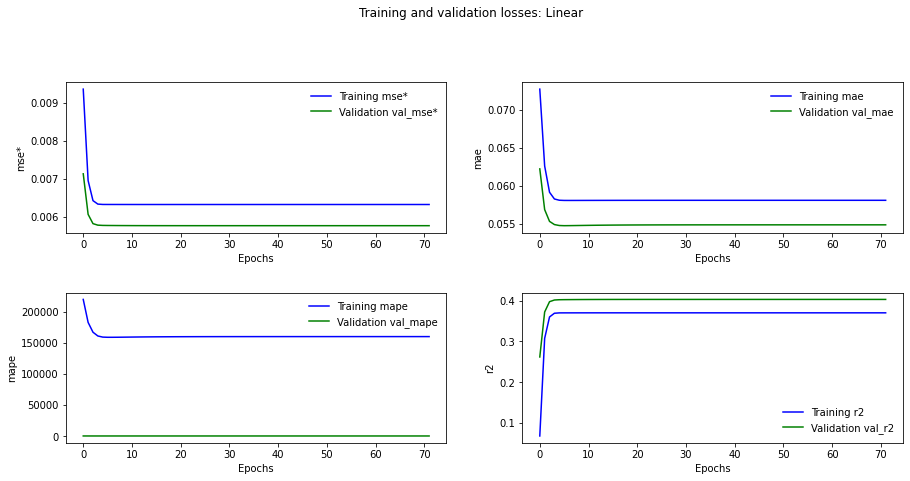

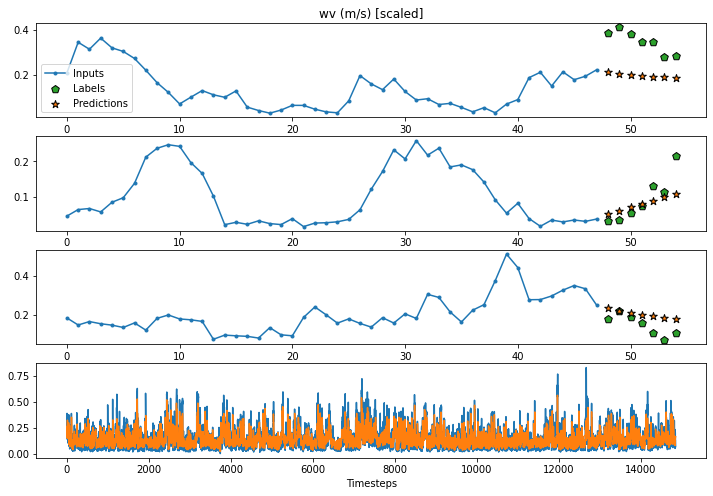

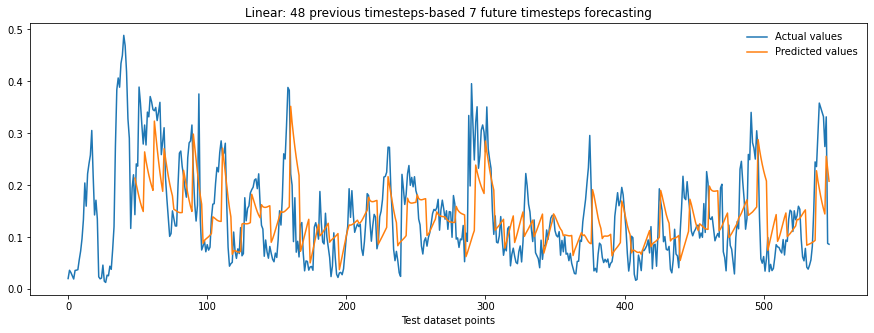

Time taken with the Linear model: 622.53 sec


In [14]:
dp_linear, mw_linear, mc_linear, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=Linear, title="Linear", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

<a id="[ConvolutionNeuralNetworkmodelresults]"></a>
### Convolution Neural Network (CNN) model results

In [15]:
class CNN(ModelingClass):
    
    def __init__(self, mapdataset, epochs, patience, learning_rate, loss, metrics, verbose=1, conv_width=3):
        super().__init__(mapdataset, epochs, patience, learning_rate, loss, metrics, verbose=1)
        self.conv_width = conv_width
        
    # build the model
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, conv_width, features]
            tf.keras.layers.Lambda(lambda x: x[:, -self.conv_width:, :]),
            # Shape => [batch, 1, conv_units]
            tf.keras.layers.Conv1D(filters=256, kernel_size=self.conv_width, activation='relu'),
            # Shape => [batch, 1,  out_steps*features]
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            ###
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
            ###
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['wv (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)



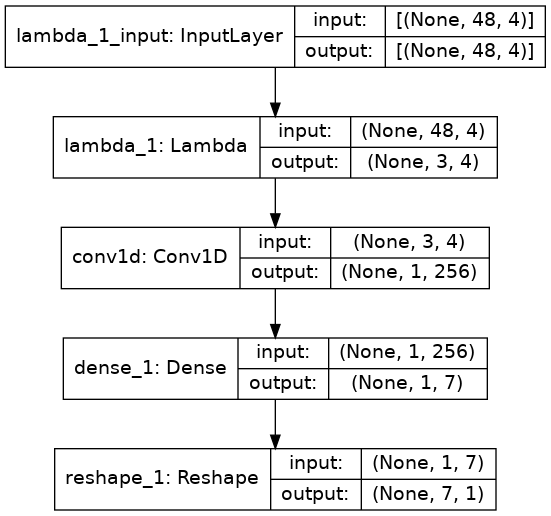


Model evaluation on train dataset:

815/815 [==============================] - 7s 9ms/step - loss: 0.0059 - mae: 0.0545 - mape: 133382.2656 - r2: 0.4171
[0.0059, 0.0545, 133382.2656, 0.4171]

Model evaluation on val dataset:

233/233 [==============================] - 2s 8ms/step - loss: 0.0053 - mae: 0.0518 - mape: 55.0855 - r2: 0.4494
[0.0053, 0.0518, 55.0855, 0.4494]

Model evaluation on test dataset:

117/117 [==============================] - 1s 8ms/step - loss: 0.0057 - mae: 0.0532 - mape: 60547.7930 - r2: 0.4299
[0.0057, 0.0532, 60547.793, 0.4299]

Modeling metrics on train data set:

rmse: 0.0751 [0.0476, 0.0633, 0.0725, 0.0794, 0.0844, 0.0881, 0.0907]
mse : 0.0058 [0.0023, 0.0040, 0.0053, 0.0063, 0.0071, 0.0078, 0.0082]
mae : 0.0545 [0.0336, 0.0449, 0.0520, 0.0574, 0.0617, 0.0649, 0.0672]
mape: 60042752819200.0000 [15910273286144.0000, 30471320764416.0000, 47217285005312.0000, 63139655712768.0000, 77524570734592.0000, 88897258258432.0000, 97138897846272.0000]
r2  : 0.4171 [0.

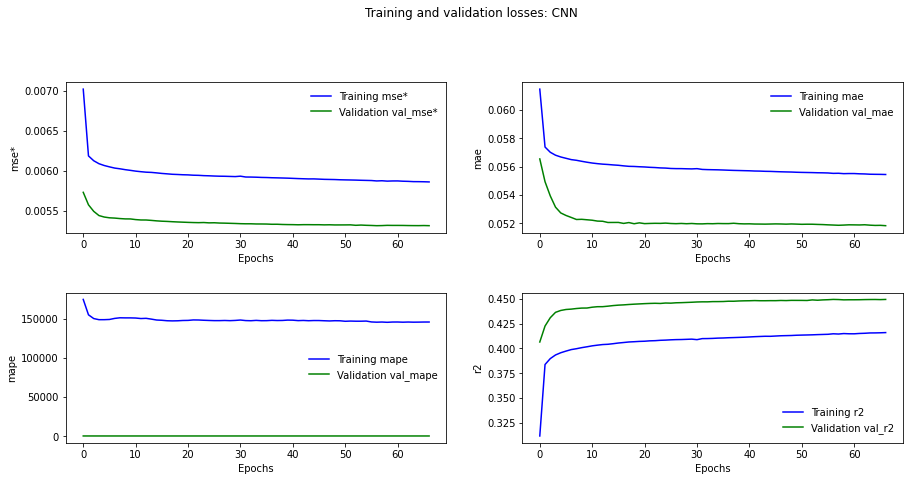

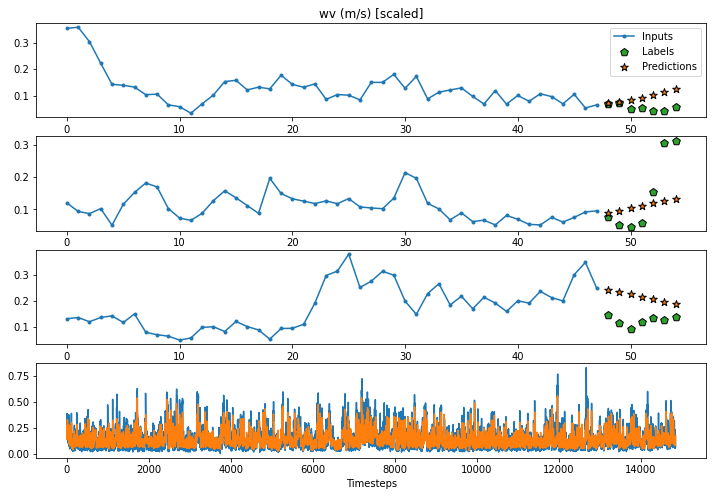

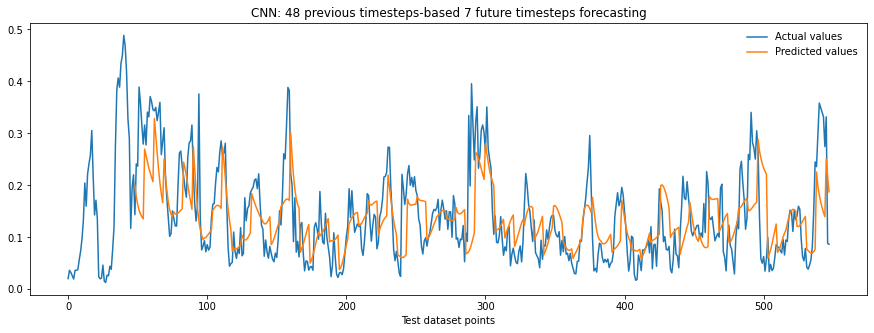

Time taken with the CNN model: 612.34 sec


In [16]:
dp_cnn, mw_cnn, mc_cnn, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=CNN, title="CNN", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

<a id="[RecurrentNeuralNetworkmodelresults]"></a>
### Recurrent Neural Network (RNN/LSTM) model results

In [17]:
class LSTM(ModelingClass):
    # build the model
    def modelbuild(self):
        # define model        
        model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, lstm_units]
            # Adding more `lstm_units` just overfits more quickly.
            tf.keras.layers.LSTM(32, return_sequences=False),
            # Shape => [batch, out_steps*features]
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['wv (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)



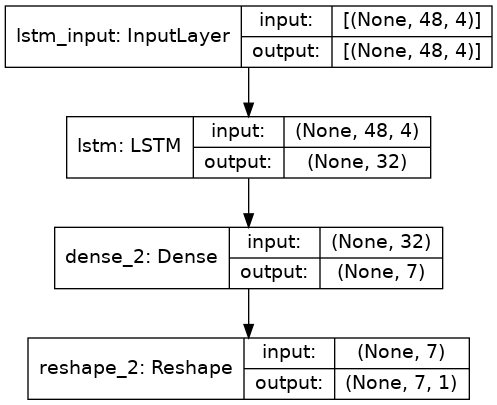


Model evaluation on train dataset:

815/815 [==============================] - 12s 14ms/step - loss: 0.0051 - mae: 0.0513 - mape: 103900.5938 - r2: 0.4956
[0.0051, 0.0513, 103900.5938, 0.4956]

Model evaluation on val dataset:

233/233 [==============================] - 4s 15ms/step - loss: 0.0048 - mae: 0.0498 - mape: 53.2213 - r2: 0.5071
[0.0048, 0.0498, 53.2213, 0.5071]

Model evaluation on test dataset:

117/117 [==============================] - 2s 14ms/step - loss: 0.0048 - mae: 0.0501 - mape: 51638.6719 - r2: 0.5164
[0.0048, 0.0501, 51638.6719, 0.5164]

Modeling metrics on train data set:

rmse: 0.0702 [0.0471, 0.0612, 0.0687, 0.0739, 0.0776, 0.0804, 0.0826]
mse : 0.0051 [0.0022, 0.0037, 0.0047, 0.0055, 0.0060, 0.0065, 0.0068]
mae : 0.0513 [0.0335, 0.0439, 0.0499, 0.0541, 0.0572, 0.0595, 0.0613]
mape: 46767174451200.0000 [12558691991552.0000, 27035292401664.0000, 40014935228416.0000, 50363176583168.0000, 59164780920832.0000, 66195017433088.0000, 72038353993728.0000]
r2  : 0.495

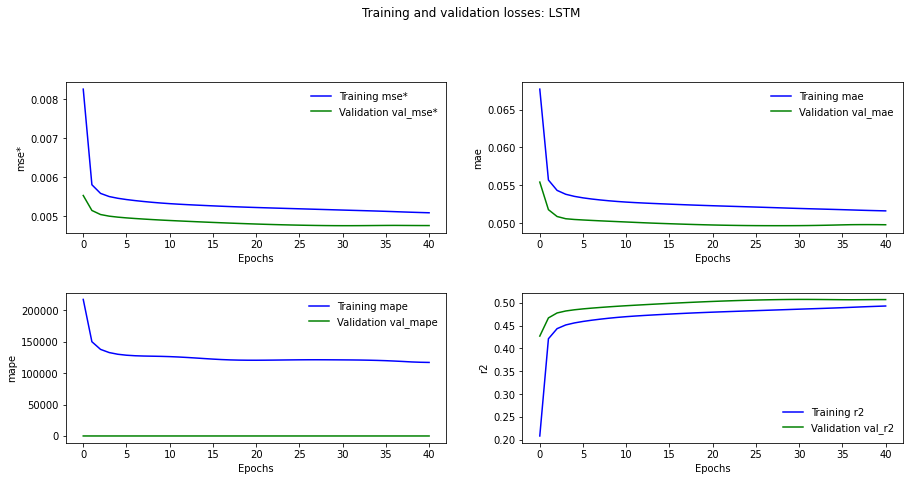

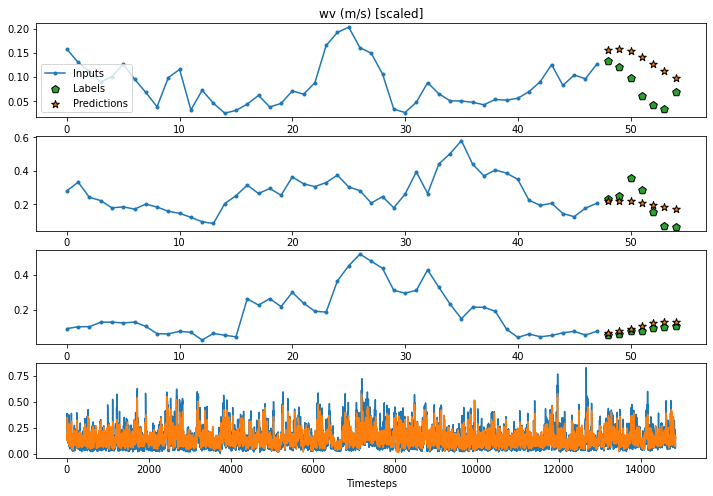

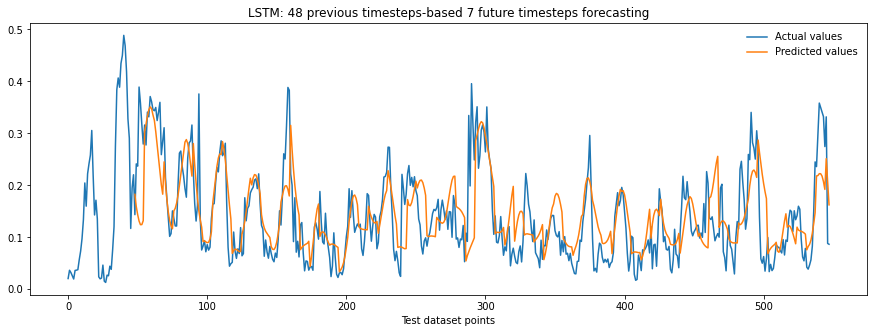

Time taken with the LSTM model: 1540.91 sec


In [18]:
dp_lstm, mw_lstm, mc_lstm, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=LSTM, title="LSTM", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

<a id="[StackedLSTMmodelresults]"></a>
### Stacked LSTM model results

In [19]:
class StackedLSTM(ModelingClass):
    # build the model
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, lstm_units]
            # Adding more `lstm_units` just overfits more quickly.
            tf.keras.layers.LSTM(10, return_sequences=True),
            tf.keras.layers.Dropout(0.2),
            #tf.keras.layers.LSTM(10, return_sequences=True),
            #tf.keras.layers.Dropout(0.2),
            #tf.keras.layers.LSTM(5, return_sequences=True),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.LSTM(5),
            tf.keras.layers.Dropout(0.2),
            # Shape => [batch, out_steps*features]
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            ###
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
            ###
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['wv (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)



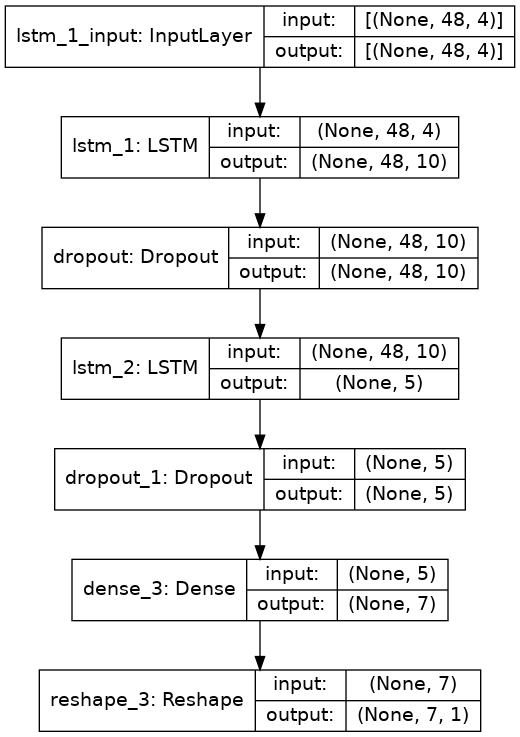


Model evaluation on train dataset:

815/815 [==============================] - 10s 13ms/step - loss: 0.0052 - mae: 0.0519 - mape: 131263.9531 - r2: 0.4823
[0.0052, 0.0519, 131263.9531, 0.4823]

Model evaluation on val dataset:

233/233 [==============================] - 3s 12ms/step - loss: 0.0048 - mae: 0.0498 - mape: 53.2495 - r2: 0.5058
[0.0048, 0.0498, 53.2495, 0.5058]

Model evaluation on test dataset:

117/117 [==============================] - 2s 13ms/step - loss: 0.0049 - mae: 0.0503 - mape: 52337.4023 - r2: 0.5067
[0.0049, 0.0503, 52337.4023, 0.5067]

Modeling metrics on train data set:

rmse: 0.0712 [0.0492, 0.0619, 0.0693, 0.0746, 0.0784, 0.0812, 0.0837]
mse : 0.0052 [0.0024, 0.0038, 0.0048, 0.0056, 0.0061, 0.0066, 0.0070]
mae : 0.0519 [0.0353, 0.0445, 0.0502, 0.0544, 0.0574, 0.0597, 0.0617]
mape: 59090121523200.0000 [29677347405824.0000, 42170287390720.0000, 52512535085056.0000, 61629089710080.0000, 69734242451456.0000, 76336794173440.0000, 81570564145152.0000]
r2  : 0.482

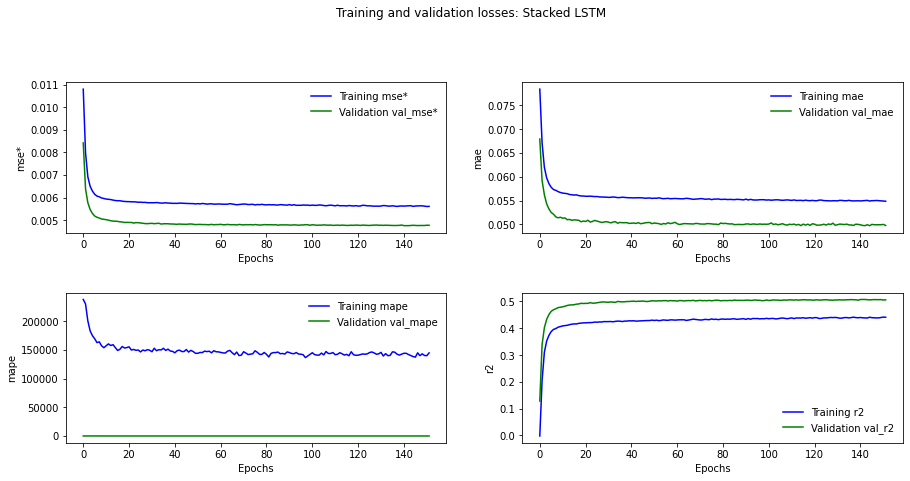

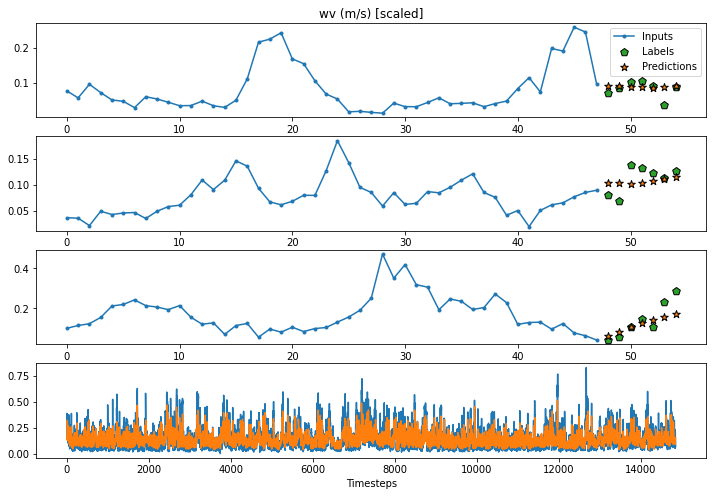

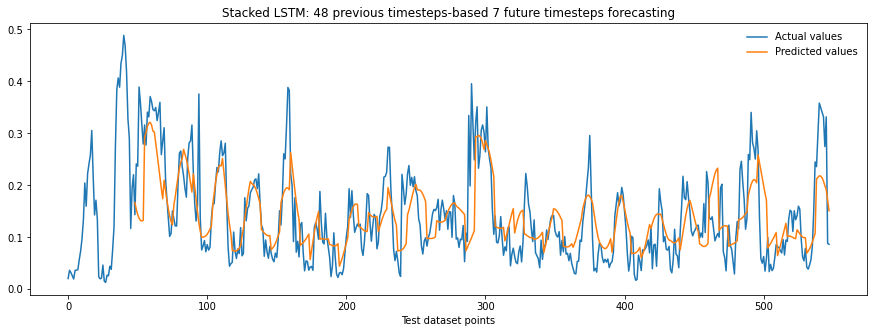

Time taken with the StackedLSTM model: 7046.48 sec


In [20]:
dp_slstm, mw_slstm, mc_slstm, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=StackedLSTM, title="Stacked LSTM", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

<a id="[StackedGRUmodelresults]"></a>
### Stacked GRU model results

In [21]:
class StackedGRU(ModelingClass):
    # build the model
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, lstm_units]
            # Adding more `gru_units` just overfits more quickly.
            tf.keras.layers.GRU(10, return_sequences=True),
            tf.keras.layers.Dropout(0.2),
            #tf.keras.layers.GRU(10, return_sequences=True),
            #tf.keras.layers.Dropout(0.2),
            #tf.keras.layers.GRU(5, return_sequences=True),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.GRU(5),
            tf.keras.layers.Dropout(0.2),
            # Shape => [batch, out_steps*features]
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            ###
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
            ###
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['wv (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)



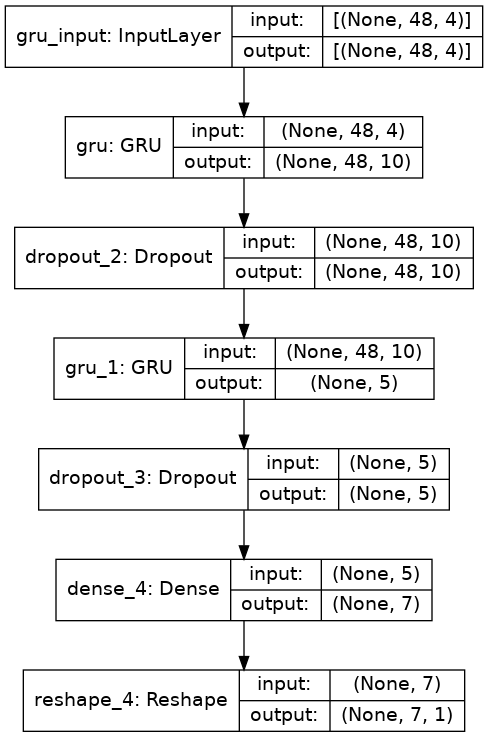


Model evaluation on train dataset:

815/815 [==============================] - 10s 12ms/step - loss: 0.0052 - mae: 0.0524 - mape: 138152.2344 - r2: 0.4789
[0.0052, 0.0524, 138152.2344, 0.4789]

Model evaluation on val dataset:

233/233 [==============================] - 3s 12ms/step - loss: 0.0048 - mae: 0.0504 - mape: 54.8950 - r2: 0.5020
[0.0048, 0.0504, 54.895, 0.502]

Model evaluation on test dataset:

117/117 [==============================] - 2s 13ms/step - loss: 0.0050 - mae: 0.0508 - mape: 51097.6602 - r2: 0.5052
[0.005, 0.0508, 51097.6602, 0.5052]

Modeling metrics on train data set:

rmse: 0.0714 [0.0490, 0.0620, 0.0697, 0.0751, 0.0787, 0.0815, 0.0838]
mse : 0.0052 [0.0024, 0.0039, 0.0049, 0.0056, 0.0062, 0.0066, 0.0070]
mae : 0.0524 [0.0354, 0.0448, 0.0508, 0.0551, 0.0581, 0.0603, 0.0623]
mape: 62191678259200.0000 [32269869776896.0000, 44260791418880.0000, 55183102967808.0000, 64767595118592.0000, 73088683212800.0000, 80174859157504.0000, 85596827549696.0000]
r2  : 0.4789 [

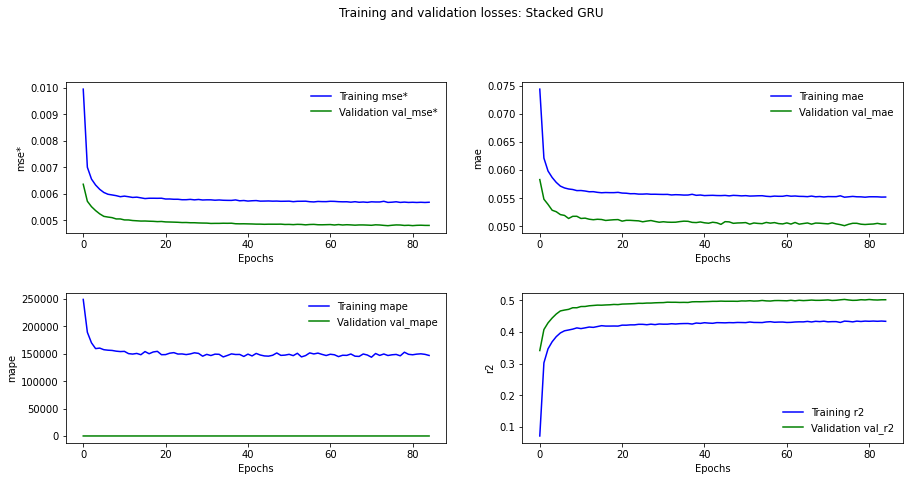

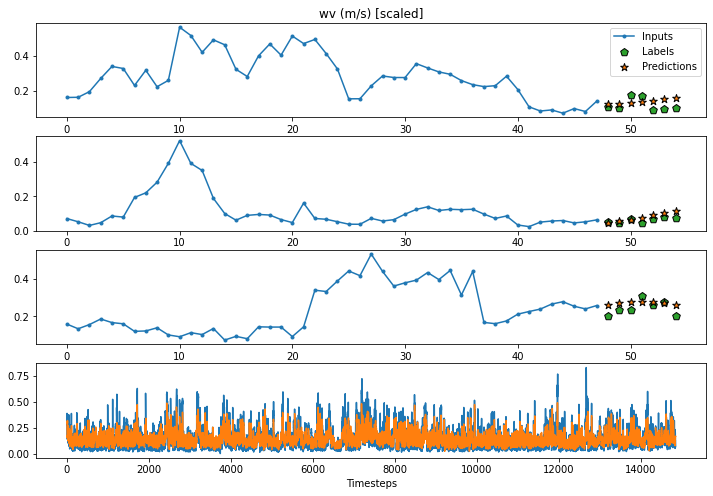

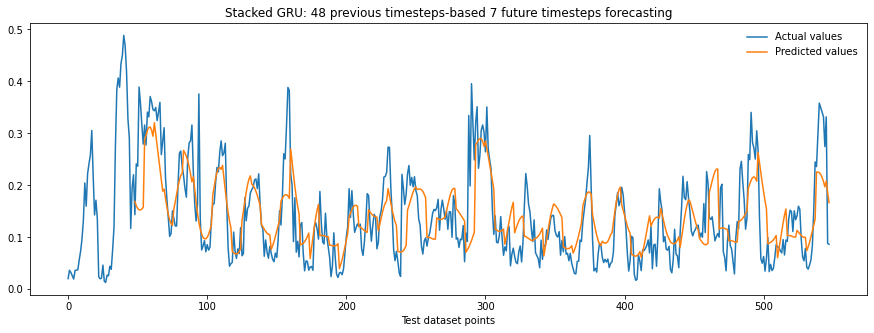

Time taken with the StackedGRU model: 3814.64 sec


In [22]:
dp_sgru, mw_sgru, mc_sgru, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=StackedGRU, title="Stacked GRU", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

<a id="[StackedBidirectionalLSTMmodelresults]"></a>
### Stacked Bidirectional LSTM model results

In [23]:
class StackedBiLSTM(ModelingClass):
    # build the model
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, lstm_units]
            # Adding more `gru_units` just overfits more quickly.
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)),
            tf.keras.layers.Dropout(0.2),
            #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)),
            #tf.keras.layers.Dropout(0.2),
            #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5, return_sequences=True)),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5)),
            tf.keras.layers.Dropout(0.2),
            # Shape => [batch, out_steps*features]
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            ###
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
            ###
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['wv (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)



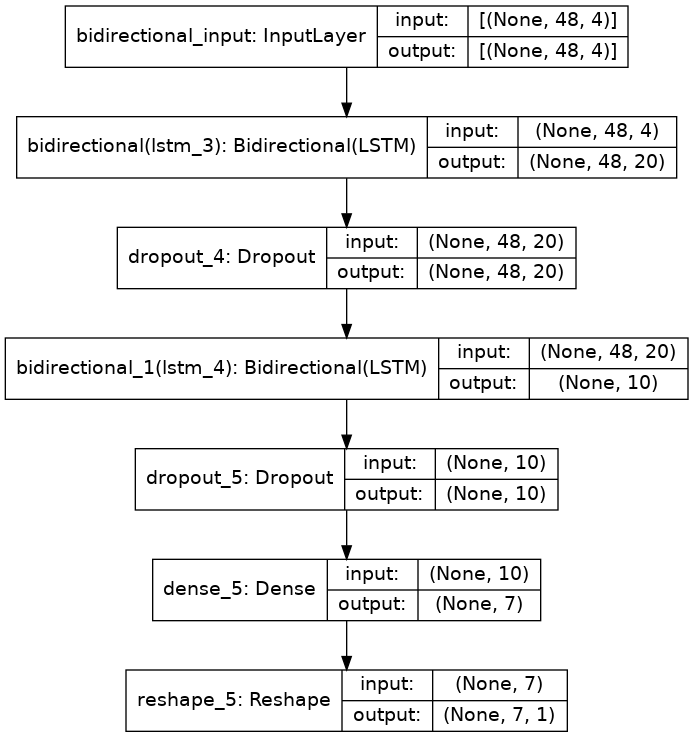


Model evaluation on train dataset:

815/815 [==============================] - 16s 20ms/step - loss: 0.0051 - mae: 0.0514 - mape: 133655.2969 - r2: 0.4919
[0.0051, 0.0514, 133655.2969, 0.4919]

Model evaluation on val dataset:

233/233 [==============================] - 5s 21ms/step - loss: 0.0048 - mae: 0.0499 - mape: 52.9278 - r2: 0.5012
[0.0048, 0.0499, 52.9278, 0.5012]

Model evaluation on test dataset:

117/117 [==============================] - 3s 21ms/step - loss: 0.0050 - mae: 0.0507 - mape: 49107.6445 - r2: 0.5024
[0.005, 0.0507, 49107.6445, 0.5024]

Modeling metrics on train data set:

rmse: 0.0704 [0.0475, 0.0611, 0.0686, 0.0739, 0.0778, 0.0808, 0.0833]
mse : 0.0051 [0.0023, 0.0037, 0.0047, 0.0055, 0.0061, 0.0065, 0.0069]
mae : 0.0514 [0.0339, 0.0440, 0.0498, 0.0540, 0.0571, 0.0595, 0.0616]
mape: 60167467827200.0000 [31985219141632.0000, 44038388449280.0000, 53471495585792.0000, 61994799464448.0000, 69642005512192.0000, 76840261648384.0000, 83200109969408.0000]
r2  : 0.4919

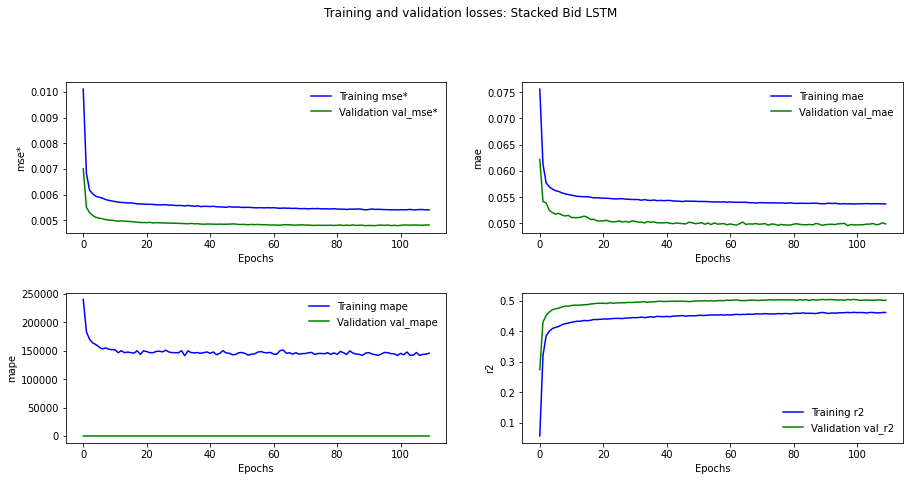

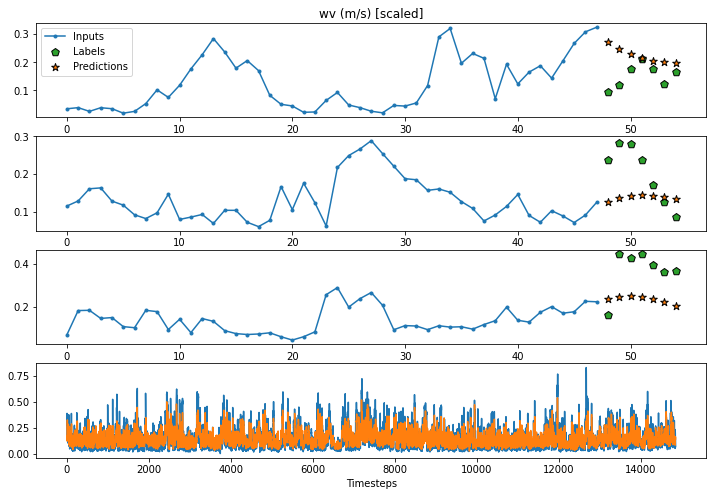

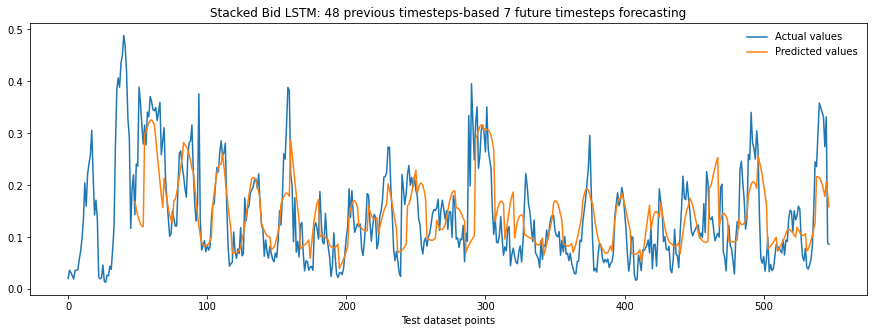

Time taken with the StackedBiLSTM model: 6024.21 sec


In [24]:
dp_sblstm, mw_sblstm, mc_sblstm, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=StackedBiLSTM, title="Stacked Bid LSTM", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

<a id="[Encoder-DecoderLSTMmodelresults]"></a>
### Encoder-Decoder LSTM model results

In [25]:
class EnDeLSTM(ModelingClass):
    # build the model 
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(10, return_sequences=False),
            tf.keras.layers.RepeatVector(self.mapdataset.label_width),   
            tf.keras.layers.LSTM(10, activation='relu', return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(5, activation='relu')),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.label_feature_number, kernel_initializer=tf.initializers.zeros)),
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['wv (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)



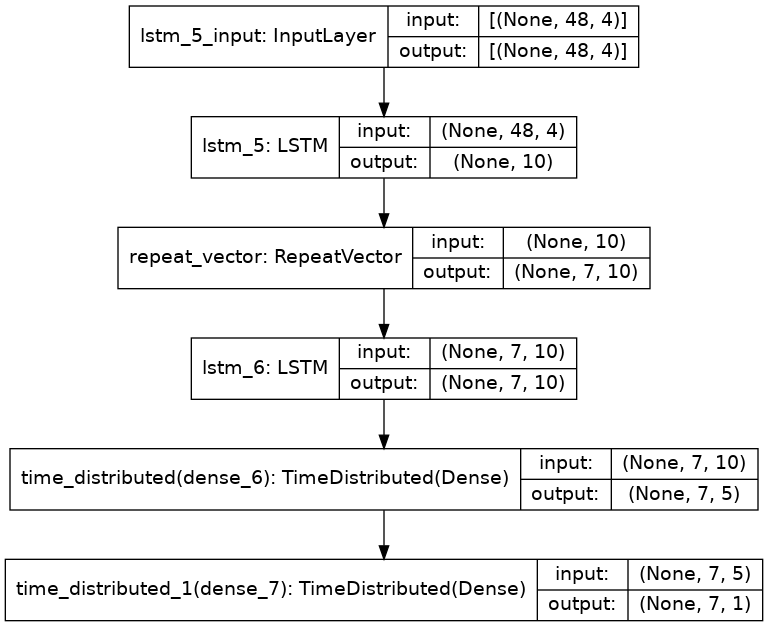


Model evaluation on train dataset:

815/815 [==============================] - 9s 11ms/step - loss: 0.0050 - mae: 0.0508 - mape: 123126.7969 - r2: 0.5022
[0.005, 0.0508, 123126.7969, 0.5022]

Model evaluation on val dataset:

233/233 [==============================] - 2s 10ms/step - loss: 0.0047 - mae: 0.0492 - mape: 52.2654 - r2: 0.5152
[0.0047, 0.0492, 52.2654, 0.5152]

Model evaluation on test dataset:

117/117 [==============================] - 1s 10ms/step - loss: 0.0048 - mae: 0.0498 - mape: 48300.6367 - r2: 0.5190
[0.0048, 0.0498, 48300.6367, 0.519]

Modeling metrics on train data set:

rmse: 0.0697 [0.0470, 0.0608, 0.0681, 0.0732, 0.0770, 0.0799, 0.0822]
mse : 0.0050 [0.0022, 0.0037, 0.0046, 0.0054, 0.0059, 0.0064, 0.0068]
mae : 0.0508 [0.0331, 0.0434, 0.0492, 0.0535, 0.0566, 0.0591, 0.0610]
mape: 55426167603200.0000 [36610930376704.0000, 44508930637824.0000, 51350452830208.0000, 56684990955520.0000, 61917372612608.0000, 66687009292288.0000, 70223470264320.0000]
r2  : 0.5022 [

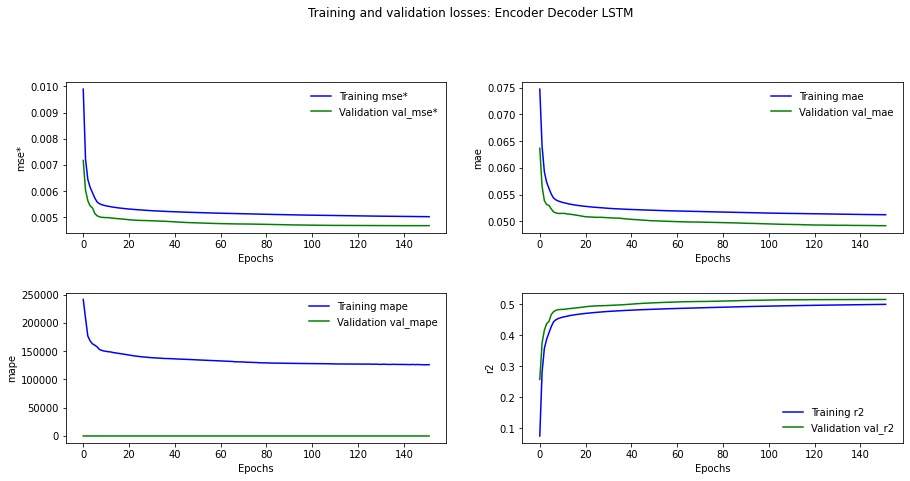

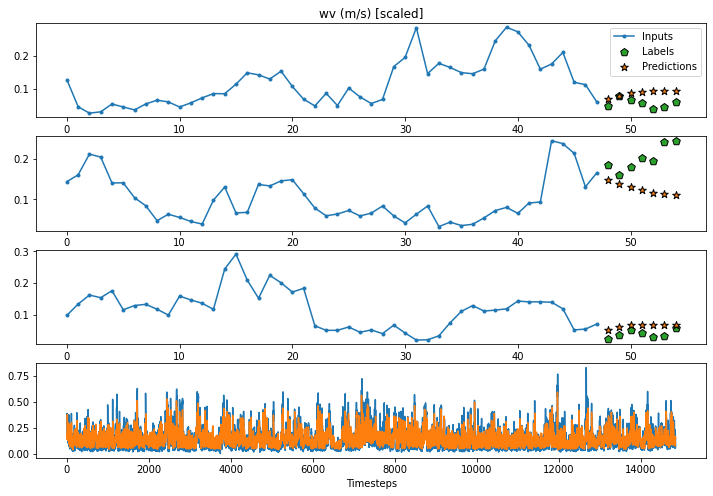

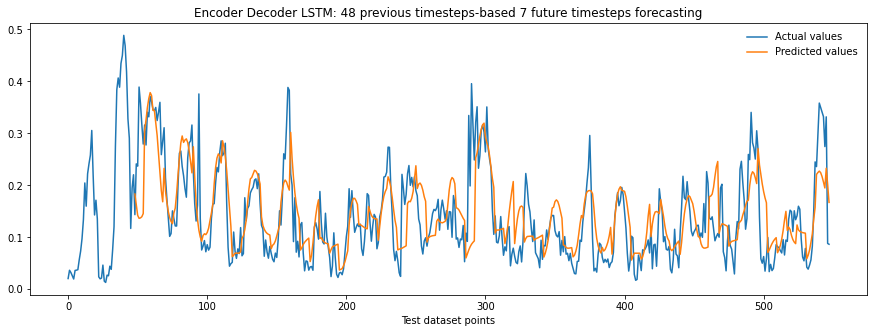

Time taken with the EnDeLSTM model: 4580.01 sec


In [26]:
dp_edlstm, mw_edlstm, mc_edlstm , train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=EnDeLSTM, title="Encoder Decoder LSTM", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

<a id="[CNN-LSTMEncoder-Decodermodelresults]"></a>
### CNN-LSTM Encoder-Decoder model results

In [27]:
class CNNLSTMEnDe(ModelingClass):
    
    def __init__(self, mapdataset, epochs, patience, learning_rate, loss, metrics, verbose=1, filters=64, conv_width=3):
        super().__init__(mapdataset, epochs, patience, learning_rate, loss, metrics, verbose=1)
        self.filters = filters
        self.conv_width = conv_width
        
    # build the model 
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([            
            tf.keras.layers.Conv1D(filters=self.filters, kernel_size=self.conv_width, activation='relu'),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.RepeatVector(self.mapdataset.label_width),
            tf.keras.layers.LSTM(10, activation='relu', return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(5, activation='relu')),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.label_feature_number, kernel_initializer=tf.initializers.zeros)),
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['wv (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)



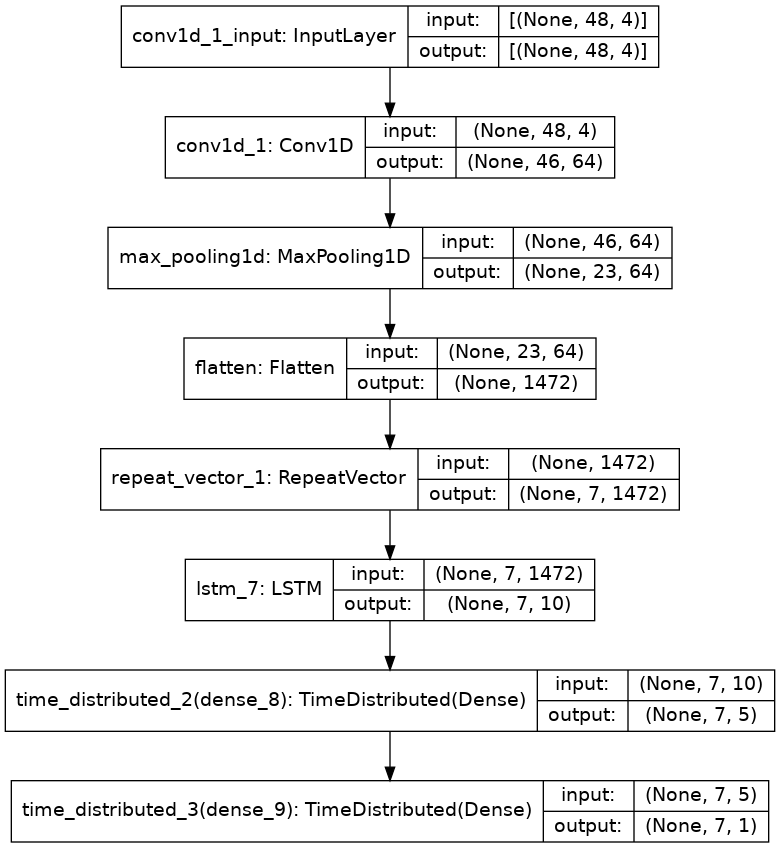


Model evaluation on train dataset:

815/815 [==============================] - 11s 13ms/step - loss: 0.0050 - mae: 0.0514 - mape: 125559.3516 - r2: 0.4998
[0.005, 0.0514, 125559.3516, 0.4998]

Model evaluation on val dataset:

233/233 [==============================] - 3s 12ms/step - loss: 0.0050 - mae: 0.0508 - mape: 53.7367 - r2: 0.4841
[0.005, 0.0508, 53.7367, 0.4841]

Model evaluation on test dataset:

117/117 [==============================] - 2s 13ms/step - loss: 0.0051 - mae: 0.0509 - mape: 49730.8320 - r2: 0.4959
[0.0051, 0.0509, 49730.832, 0.4959]

Modeling metrics on train data set:

rmse: 0.0701 [0.0498, 0.0618, 0.0683, 0.0729, 0.0764, 0.0793, 0.0821]
mse : 0.0050 [0.0025, 0.0038, 0.0047, 0.0053, 0.0058, 0.0063, 0.0067]
mae : 0.0514 [0.0360, 0.0446, 0.0497, 0.0535, 0.0564, 0.0587, 0.0608]
mape: 56521608396800.0000 [43495557431296.0000, 47805188014080.0000, 52329315303424.0000, 56422163283968.0000, 60691901841408.0000, 65622364913664.0000, 69284776640512.0000]
r2  : 0.4998 [

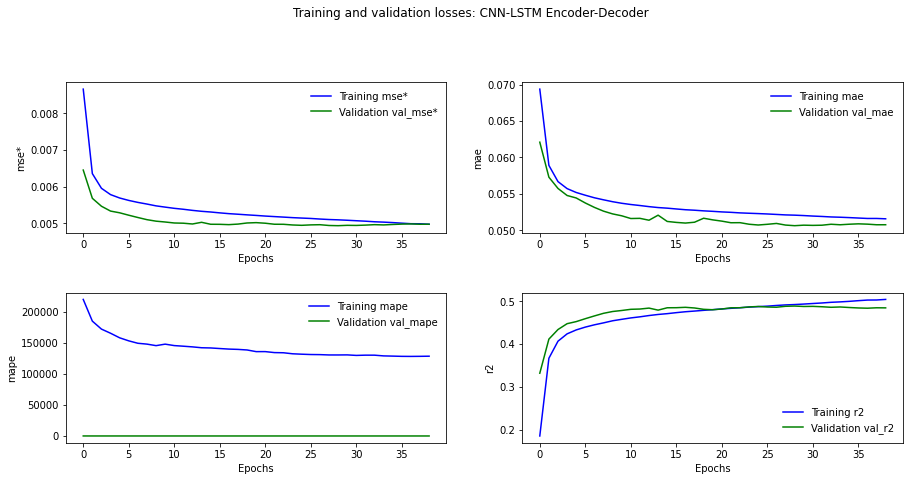

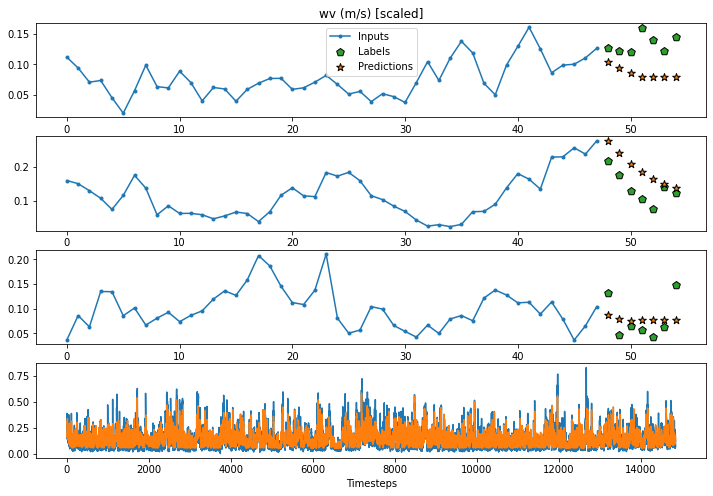

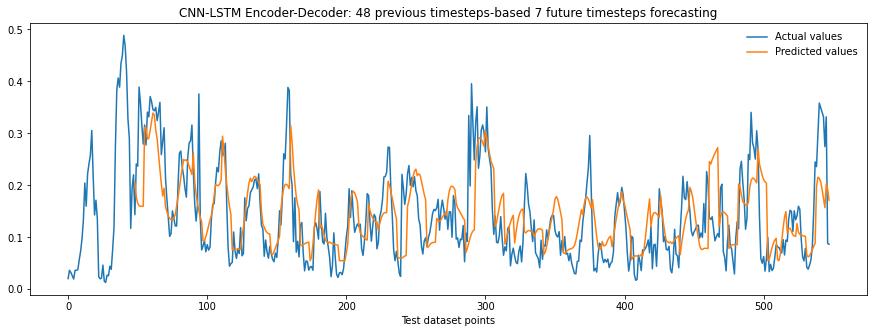

Time taken with the CNNLSTMEnDe model: 1016.54 sec


In [28]:
dp_cnnlstmed, mw_cnnlstmed, mc_cnnlstmed , train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=CNNLSTMEnDe, title="CNN-LSTM Encoder-Decoder", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

<a id="[ConvLSTMEncoder-Decodermodelresults]"></a>
### ConvLSTM Encoder-Decoder model results

In [29]:
class ConvLSTMEnDe(ModelingClass):
    
    def __init__(self, mapdataset, epochs, patience, learning_rate, loss, metrics, verbose=1, filters=64):
        super().__init__(mapdataset, epochs, patience, learning_rate, loss, metrics, verbose=1)
        
        self.filters = filters
        
        self.train_x = np.concatenate(list(map(lambda x: x[0].numpy(), mapdataset.train)))
        #self.train_x = np.vstack(np.array(list(map(lambda x: x[0].numpy(), mapdataset.train)), dtype=object))
        self.train_y = np.concatenate(list(map(lambda x: x[1].numpy(), mapdataset.train)))
        self.val_x = np.concatenate(list(map(lambda x: x[0].numpy(), mapdataset.val)))
        self.val_y = np.concatenate(list(map(lambda x: x[1].numpy(), mapdataset.val)))
        self.test_x = np.concatenate(list(map(lambda x: x[0].numpy(), mapdataset.test)))
        self.test_y = np.concatenate(list(map(lambda x: x[1].numpy(), mapdataset.test)))
    
    def getFactors(self, n):
        factors = []
        for i in range(1, n + 1):
            if n % i == 0:
                factors.append(i)
        if len(factors) == 2:
            return (factors[0], n)
        else:
            return (factors[1], int(n / factors[1]))
    @property
    def reshapeparams(self):
        return self.getFactors(self.mapdataset.input_width)
    
    def reshape(self, data):
        data = data.reshape(data.shape[0], self.reshapeparams[0], 1, self.reshapeparams[1], data.shape[2])
        return data
        
    @property
    def trainreshape(self):
        return self.reshape(self.train_x)
    @property
    def valreshape(self):
        return self.reshape(self.val_x)
    @property
    def testreshape(self):
        return self.reshape(self.test_x)
        
    # build the model 
    def modelbuild(self):
        # define model
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(self.trainreshape.shape[1], self.trainreshape.shape[2], self.trainreshape.shape[3], self.trainreshape.shape[4])), 
            tf.keras.layers.ConvLSTM2D(filters=self.filters, kernel_size=(1, self.mapdataset.label_width), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.RepeatVector(self.train_y.shape[1]),
            tf.keras.layers.LSTM(10, activation='relu', return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(5, activation='relu')),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.label_feature_number)),
            ])
        return model

    # train the model
    def train(self):
        # Building the model
        self.model = self.modelbuild()
        # Initiating the optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # Instantiate an optimizer before passing it to model.compile() or pass it by its string identifier.
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
        # fit network
        if (self.val_x is not None) & (self.val_y is not None):
            self.history = self.model.fit(
                self.trainreshape,
                self.train_y,
                validation_data=(self.valreshape, self.val_y),
                epochs=self.epochs, 
                batch_size=self.mapdataset.batch_size, 
                verbose=self.verbose, 
                shuffle=False,
                callbacks=[self.traincallback()],
            )
        else:           
            self.history = self.model.fit(
                self.trainreshape,
                self.train_y,
                epochs=self.epochs, 
                batch_size=self.mapdataset.batch_size, 
                verbose=self.verbose, 
                shuffle=False,
                callbacks=[self.traincallback()],
            )
        return self.history
    
    def modelevaluate(self, train_performance, val_performance, test_performance):
        for x in ["train", "val", "test"]:
            print("\nModel evaluation on %s dataset:\n"%x)
            eval("%s_performance"%x)[self.__class__.__name__] = self.model.evaluate(eval("self.%sreshape"%x), eval("self.%s_y"%x), batch_size=self.mapdataset.batch_size)  
            print(list(map(lambda x: round(x, 4), eval("%s_performance"%x)[self.__class__.__name__])))
        return train_performance, val_performance, test_performance

    def computemetrics(self, reshape_real_x, real_y): 
        real_y = real_y.reshape(real_y.shape[0], real_y.shape[1])
        pred_y = self.model.predict(reshape_real_x)
        pred_y = pred_y.reshape(pred_y.shape[0], pred_y.shape[1])

        RMSE = mean_squared_error(real_y, pred_y, squared=False)
        MSE = mean_squared_error(real_y, pred_y)
        MAE = mean_absolute_error(real_y, pred_y)
        MAPE = 100*mean_absolute_percentage_error(real_y, pred_y)
        R2 = r2_score(real_y, pred_y)   
        # calculate the metric score for each timestep
        rmse_scores = mean_squared_error(real_y, pred_y, multioutput='raw_values', squared=False)
        mse_scores = mean_squared_error(real_y, pred_y, multioutput='raw_values')
        mae_scores = mean_absolute_error(real_y, pred_y, multioutput='raw_values')
        mape_scores = 100*mean_absolute_percentage_error(real_y, pred_y, multioutput='raw_values')
        r2_scores = r2_score(real_y, pred_y, multioutput='raw_values')
        print('rmse: %.4f [%s]' %(RMSE, ', '.join(['%.4f' % s for s in rmse_scores])))
        print('mse : %.4f [%s]' %(MSE, ', '.join(['%.4f' % s for s in mse_scores])))
        print('mae : %.4f [%s]' %(MAE, ', '.join(['%.4f' % s for s in mae_scores])))
        print('mape: %.4f [%s]' %(MAPE, ', '.join(['%.4f' % s for s in mape_scores])))
        print('r2  : %.4f [%s]' %(R2, ', '.join(['%.4f' % s for s in r2_scores]))) 
    
    @property
    def trainmetrics(self):
        return self.computemetrics(self.trainreshape, self.train_y)
    @property
    def valmetrics(self):
        return self.computemetrics(self.valreshape, self.val_y)
    @property
    def testmetrics(self):
        return self.computemetrics(self.testreshape, self.test_y)

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['wv (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)



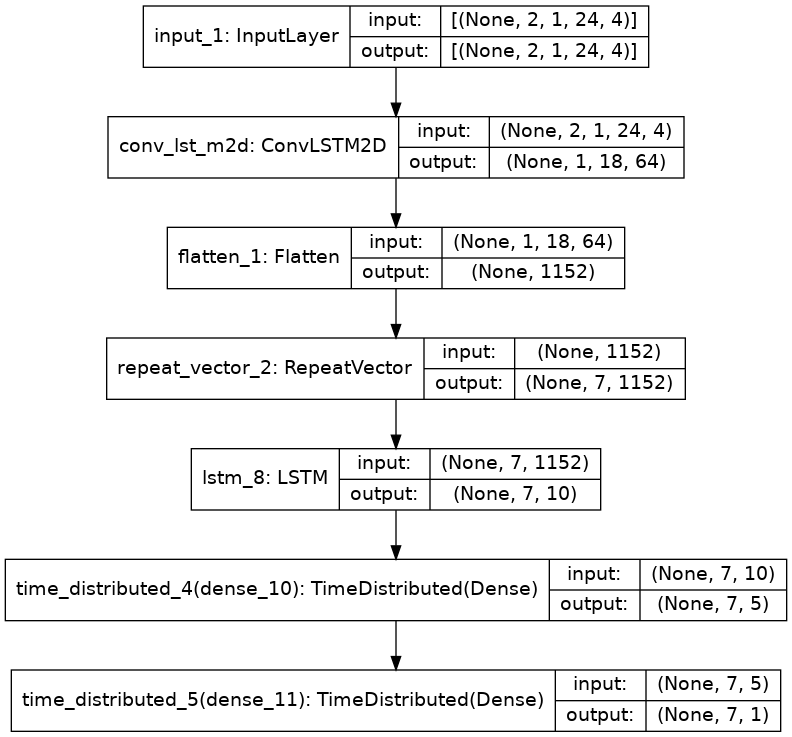


Model evaluation on train dataset:

815/815 [==============================] - 19s 23ms/step - loss: 0.0050 - mae: 0.0514 - mape: 130046.5469 - r2: 0.5046
[0.005, 0.0514, 130046.5469, 0.5046]

Model evaluation on val dataset:

233/233 [==============================] - 6s 25ms/step - loss: 0.0049 - mae: 0.0511 - mape: 55.7147 - r2: 0.4903
[0.0049, 0.0511, 55.7147, 0.4903]

Model evaluation on test dataset:

117/117 [==============================] - 3s 23ms/step - loss: 0.0050 - mae: 0.0514 - mape: 52121.9180 - r2: 0.4976
[0.005, 0.0514, 52121.918, 0.4976]

Modeling metrics on train data set:

rmse: 0.0696 [0.0478, 0.0609, 0.0680, 0.0729, 0.0765, 0.0794, 0.0820]
mse : 0.0050 [0.0023, 0.0037, 0.0046, 0.0053, 0.0058, 0.0063, 0.0067]
mae : 0.0514 [0.0344, 0.0443, 0.0500, 0.0540, 0.0569, 0.0592, 0.0612]
mape: 58541657292800.0000 [37508918280192.0000, 46526881595392.0000, 54566942932992.0000, 60571118469120.0000, 66139342241792.0000, 70568309161984.0000, 73910062153728.0000]
r2  : 0.5046 [

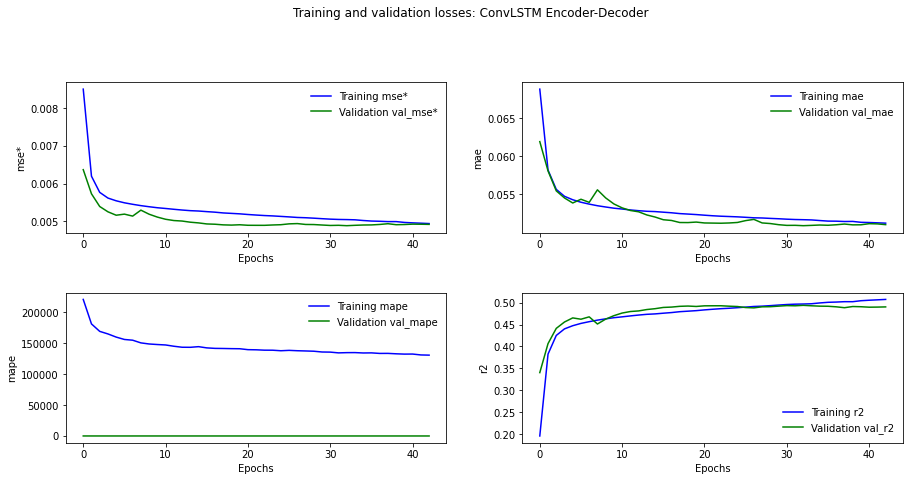

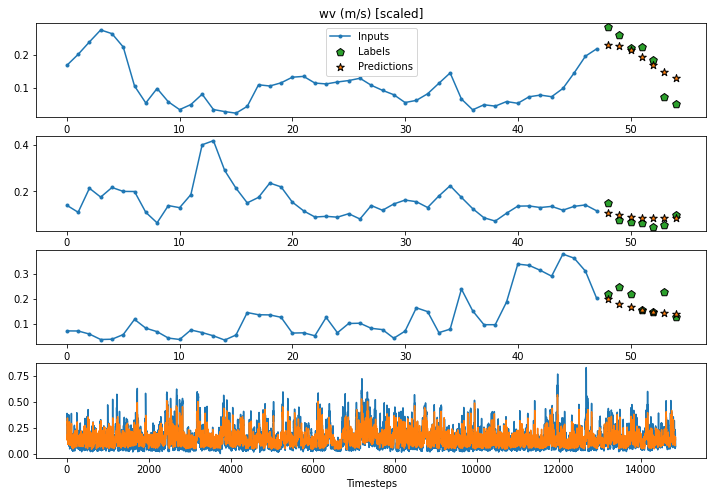

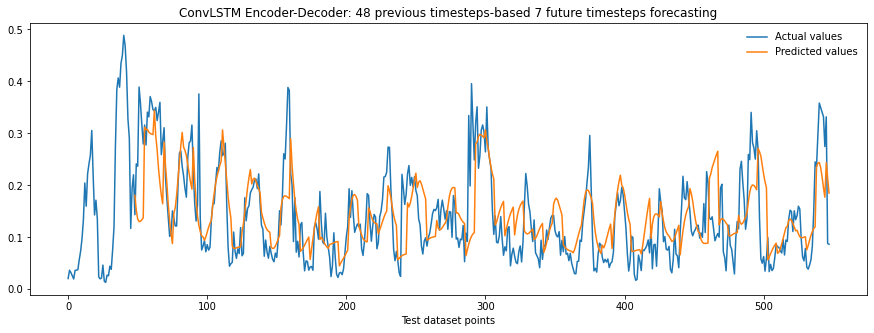

Time taken with the ConvLSTMEnDe model: 3202.16 sec


In [30]:
dp_convlstmed, mw_convlstmed, mc_convlstmed , train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=ConvLSTMEnDe, title="ConvLSTM Encoder-Decoder", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

<a id="[Performanceresults]"></a>
## Performance results

In [31]:
def perfplot(train_performance, val_performance, test_performance, metric_name, anymodel, ylabel):
    # set width of bar
    barWidth = 0.25
    # set height of bar      
    metric_index = anymodel.metrics_names.index(metric_name)
    train_metric = [v[metric_index] for v in train_performance.values()]
    val_metric = [v[metric_index] for v in val_performance.values()]
    test_metric = [v[metric_index] for v in test_performance.values()]
    # Set position of bar on X axis
    r1 = np.arange(len(test_performance))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    # Make the plot
    plt.figure(figsize=(14, 8))
    plt.bar(r1, train_metric, width=barWidth, label='Train')
    plt.bar(r2, val_metric, width=barWidth, label='Validation')
    plt.bar(r3, test_metric, width=barWidth, label='Test')        
    # Set axis label
    plt.ylabel(ylabel)
    # Add xticks on the middle of the group bars
    plt.xticks([r + barWidth for r in range(len(test_performance))], 
               labels=test_performance.keys(), rotation=45)
    plt.legend()
    plt.show()
    
    print(pd.DataFrame(np.array([train_metric, val_metric, test_metric]),
                 columns=test_performance.keys(), 
                 index=["Train", "Val", "Test"]).round(4).transpose())

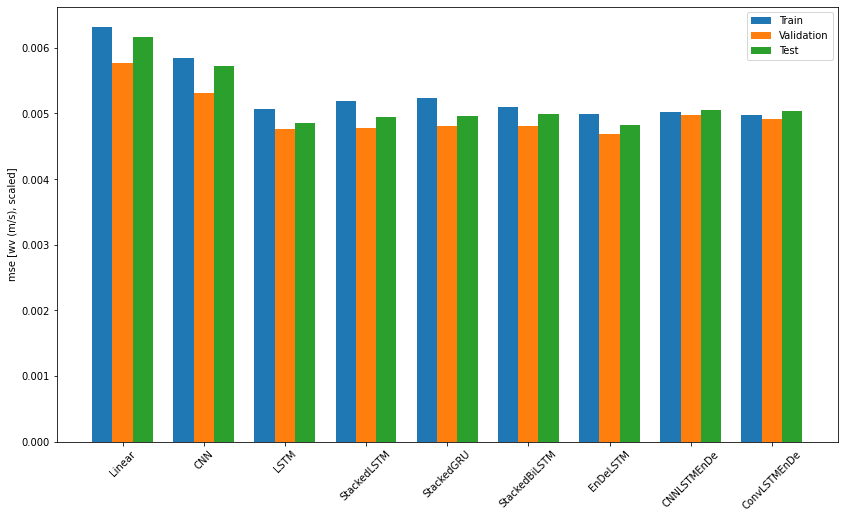

                Train     Val    Test
Linear         0.0063  0.0058  0.0062
CNN            0.0059  0.0053  0.0057
LSTM           0.0051  0.0048  0.0048
StackedLSTM    0.0052  0.0048  0.0049
StackedGRU     0.0052  0.0048  0.0050
StackedBiLSTM  0.0051  0.0048  0.0050
EnDeLSTM       0.0050  0.0047  0.0048
CNNLSTMEnDe    0.0050  0.0050  0.0051
ConvLSTMEnDe   0.0050  0.0049  0.0050


In [32]:
perfplot(train_performance, val_performance, test_performance, metric_name='loss', anymodel=mc_slstm.model, ylabel='mse [wv (m/s), scaled]')

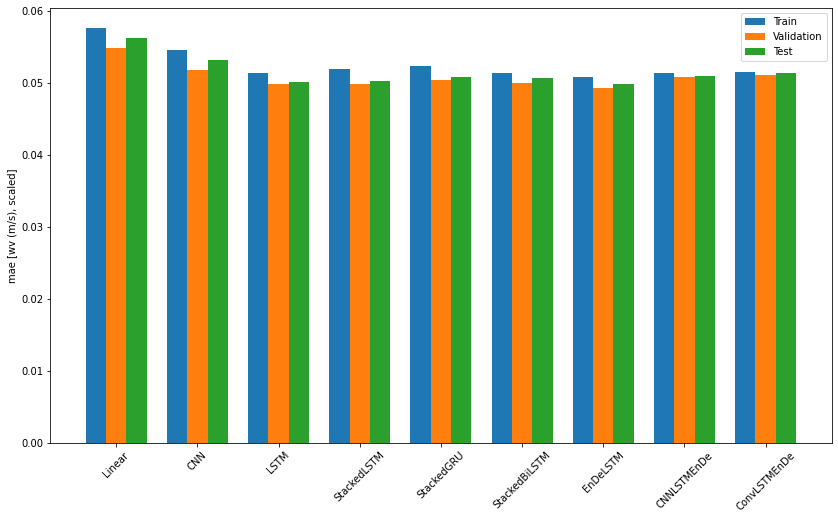

                Train     Val    Test
Linear         0.0575  0.0549  0.0562
CNN            0.0545  0.0518  0.0532
LSTM           0.0513  0.0498  0.0501
StackedLSTM    0.0519  0.0498  0.0503
StackedGRU     0.0524  0.0504  0.0508
StackedBiLSTM  0.0514  0.0499  0.0507
EnDeLSTM       0.0508  0.0492  0.0498
CNNLSTMEnDe    0.0514  0.0508  0.0509
ConvLSTMEnDe   0.0514  0.0511  0.0514


In [33]:
perfplot(train_performance, val_performance, test_performance, metric_name='mae', anymodel=mc_slstm.model, ylabel='mae [wv (m/s), scaled]')

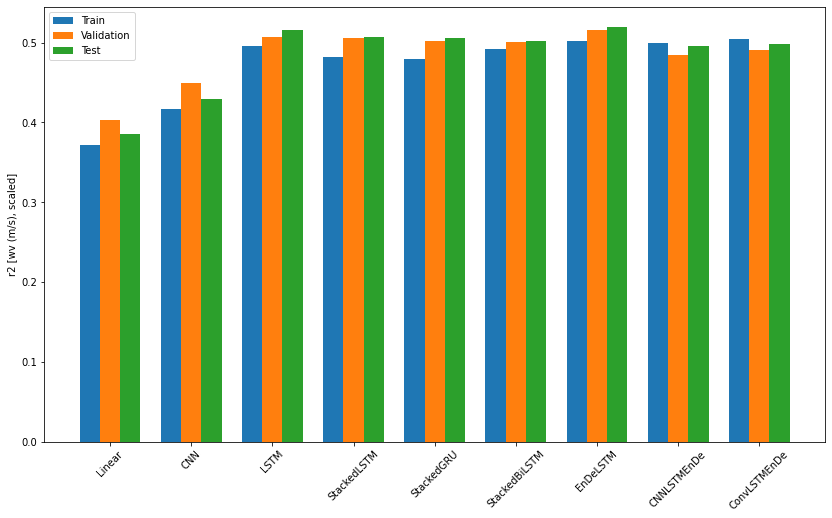

                Train     Val    Test
Linear         0.3711  0.4029  0.3860
CNN            0.4171  0.4494  0.4299
LSTM           0.4956  0.5071  0.5164
StackedLSTM    0.4823  0.5058  0.5067
StackedGRU     0.4789  0.5020  0.5052
StackedBiLSTM  0.4919  0.5012  0.5024
EnDeLSTM       0.5022  0.5152  0.5190
CNNLSTMEnDe    0.4998  0.4841  0.4959
ConvLSTMEnDe   0.5046  0.4903  0.4976


In [34]:
perfplot(train_performance, val_performance, test_performance, metric_name='r2', anymodel=mc_slstm.model, ylabel='r2 [wv (m/s), scaled]')

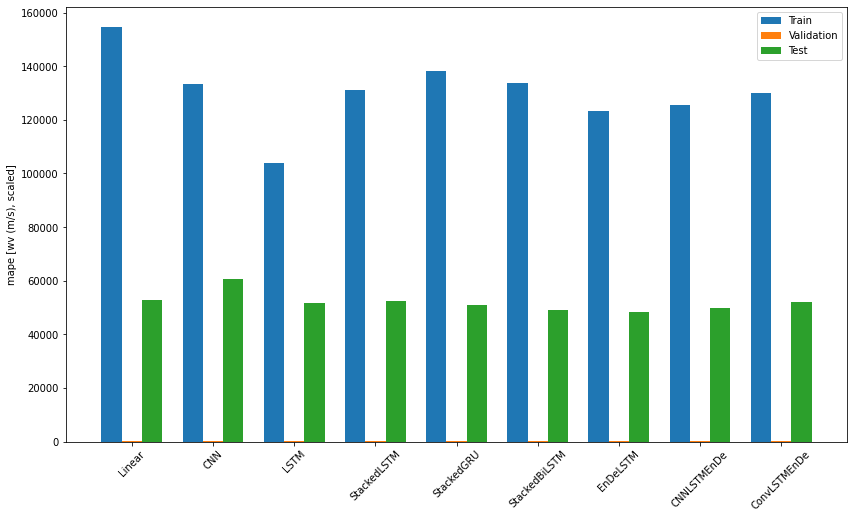

                     Train      Val        Test
Linear         154490.7344  60.4915  52868.8750
CNN            133382.2656  55.0855  60547.7930
LSTM           103900.5938  53.2213  51638.6719
StackedLSTM    131263.9531  53.2495  52337.4023
StackedGRU     138152.2344  54.8950  51097.6602
StackedBiLSTM  133655.2969  52.9278  49107.6445
EnDeLSTM       123126.7969  52.2654  48300.6367
CNNLSTMEnDe    125559.3516  53.7367  49730.8320
ConvLSTMEnDe   130046.5469  55.7147  52121.9180


In [35]:
perfplot(train_performance, val_performance, test_performance, metric_name='mape', anymodel=mc_slstm.model, ylabel='mape [wv (m/s), scaled]')